<a href="https://colab.research.google.com/github/ada-zhou/bay_area_housing/blob/main/CS145Project3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Run this cell to authenticate yourself to BigQuery.
from google.colab import auth
auth.authenticate_user() 
project_id = "cs145-proj3-final"

In [ ]:
# Initialize BiqQuery client
from google.cloud import bigquery
client = bigquery.Client(project=project_id)

In [ ]:
# Add imports for any visualization libraries you may need
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline


**Project Overview**



*Central Question*: What characteristics in the Bay Area contribute to rent relative to income and housing value relative to income?

Housing affordabilty is the pressing issue of the Bay Area. The social consensus is that housing values are extremely high and rents are similarly too high causing many people in the Bay to be housing insecure. The phrase "house rich, cash poor" is often used to describe homeowners in the Bay Area meaning that even though housing values have increased more dramatically than income. We wanted to explore this statement in depth by examining housing values relative to the income of the house owners and rents relative to the income of the renters. We explored how these two metrics rose or fell depending the demographic characteristics of the residents in the Bay Area using the Census ACS Dataset.

Supplementary Questions:

* How has housing value changed over the years in the Bay Area? How has renting prices changed over the years? How has incomes changed?
* Is there evidence for “house rich, cash poor” ?
* How does the distribution of income across the Bay affect housing and rent relative to income?
* Are people of different income brackets more likely to be housing insecure?
* Are families more or less housing secure than non family households?
* Where is new construction of housing taking place?
* What are the similarities and differences between the 9 counties that make up the Bay Area?
* How does housing affordability relate to household migrations in and out of the Bay?
* How does ethnicity affect housing affordability? How does occupation affect housing affordability? How does education affect housing affordability?










**Anlaysis of Dataset**

The Census ACS Dataset has demographic data on population broken down in different levels across different time periods. They have data ranging from state level to block level. The specific subset of tables from this dataset that we decided to focus on are the ones that record data on the census tract level. A census tract is an area that the Census determines as essentially a neighborhood. We chose this granularity because the Census draws census tracts to encompass between 2,500 - 8,000 people and do not often change. The block level which is one level more granular than census tracts was too small of a population that some data points such as employment was not included in those tables. Congressional districts, which is one level less granular than census tracts, did not have any more data points than census tracts. 

The census tract subset of the dataset includes 8 tables that are each around 140 MB in size (total subset size ~ 1.12 GB). The 8 tables include data released from 2010-2017. Each table includes the same demographic data collected over the 5 year period prior to the release of the data. Each table includes data on each census tract in the United States. Census tracts are identified by a unique 11 digit geoid where the first two digits indicate the state of the census tract and the next three digits indicate the county of the census tract and so on. The geoid is the key for each table. The geoid is also the foreign key between the 8 tables, since the other columns is data on that specific census tract throughout the years. 

Demographic data included in the tablescan be broken down into different sections such as number of family and nonfamily households, rent information, ethnicity breakdown, housing structure information,  income information, age information, gender information, employment information, education information, commuting information, etc. In each section there are usually multiple columns that help elucidate that section of demographic information. For example for ethnicity breakdown, there are columns that indicate the number of people in that census tract who identify as hispanic, white, black, asian, two or more ethnicities, etc. There are other sections such as income where the census has broken down annual incomes to ranges. 

**Exploring your questions, with appropriate visualizations**

**Bay Area Rental and Home Ownership Market Overview**

Our first queries were made to give us a better understanding of how the Bay Area Rental and Home Ownership Market looked like and changed throughout the years in comparison to the US. We looked at rent, housing value, and income trends individually first. Then we used these graphs to help us decide the values with which we would use to compute the relative value of rent/housing value to income since there was more than one data points in the Census database for that information (for example, ‘median income’ and ‘income per capita’). We chose housing_value_median, median_rent and income_per_capita as the values would use to calculate our rent/housing value to income relativity scores. Once we chose these to help calculate relativity scores, we visualized the trends for the relativity scores throughout the years. The comparison with the overall US averages was helpful to put in context the scale of the numbers. 

In [ ]:
%%bigquery --project $project_id intro_bay

SELECT
  year,
  AVG(owner_occupied_housing_units_lower_value_quartile) AS housing_value_lower,
  AVG(owner_occupied_housing_units_median_value) AS housing_value_median,
  AVG(owner_occupied_housing_units_upper_value_quartile) AS housing_value_upper,
  AVG(renter_occupied_housing_units_paying_cash_median_gross_rent) AS rent_cash_gross_rent,
  AVG(median_rent) AS median_rent,
  AVG(income_per_capita) AS income_per_capita,
  AVG(median_income) AS median_income
FROM
  `cs145-proj3-final.cs145_proj3.censustract_concat_bay`
GROUP BY
  year
ORDER BY
  year

In [ ]:
%%bigquery --project $project_id intro_us

SELECT
  year,
    AVG(owner_occupied_housing_units_lower_value_quartile) AS housing_value_lower,
  AVG(owner_occupied_housing_units_median_value) AS housing_value_median,
  AVG(owner_occupied_housing_units_upper_value_quartile) AS housing_value_upper,
  AVG(renter_occupied_housing_units_paying_cash_median_gross_rent) AS rent_cash_gross_rent,
  AVG(median_rent) AS median_rent,
  AVG(income_per_capita) AS income_per_capita,
  AVG(median_income) AS median_income
FROM
  `cs145-proj3-final.cs145_proj3.censustract_concat`
WHERE median_rent IS NOT NULL AND owner_occupied_housing_units_median_value IS NOT NULL
GROUP BY
  year
ORDER BY
  year

Text(0, 0.5, 'Rent')

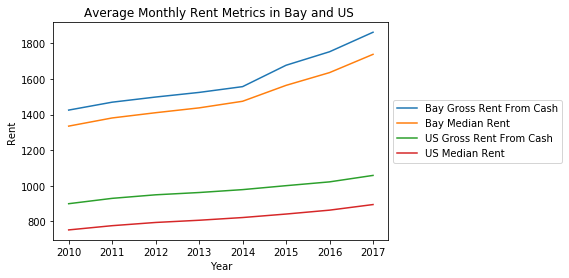

In [ ]:
fig, ax = plt.subplots()
plt.plot(intro_bay["year"], intro_bay["rent_cash_gross_rent"],  label = 'Bay Gross Rent From Cash')
plt.plot(intro_bay["year"], intro_bay["median_rent"],  label = 'Bay Median Rent')
plt.plot(intro_us["year"], intro_us["rent_cash_gross_rent"],  label = 'US Gross Rent From Cash')
plt.plot(intro_us["year"], intro_us["median_rent"],  label = 'US Median Rent')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.title("Average Monthly Rent Metrics in Bay and US ")
plt.xlabel("Year")
plt.ylabel("Rent")

Monthly rent is generally increasing in the overall US, however, the rent is increasing more in the Bay Area. The average rents across the Bay Area is around 1.5x the amount across the US.

Text(0, 0.5, 'Income')

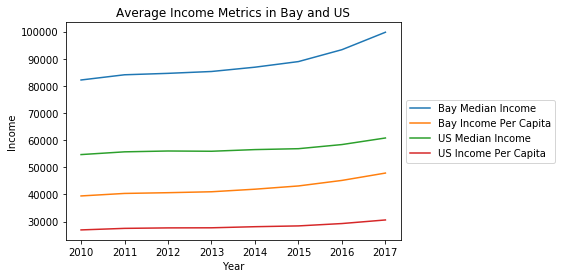

In [ ]:
fig, ax = plt.subplots()
plt.plot(intro_bay["year"], intro_bay["median_income"],  label = 'Bay Median Income')
plt.plot(intro_bay["year"], intro_bay["income_per_capita"],  label = 'Bay Income Per Capita')
plt.plot(intro_us["year"], intro_us["median_income"],  label = 'US Median Income')
plt.plot(intro_us["year"], intro_us["income_per_capita"],  label = 'US Income Per Capita')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.title("Average Income Metrics in Bay and US")
plt.xlabel("Year")
plt.ylabel("Income")

The median income is greater than the income per capita. The Bay Area income is increasing from 2015-2017 whereas there’s only a slight tilt upwards for the US. We thought that using income per capita would paint a better picture of the incomes of everyone in a census tract compared to the median income.

Text(0, 0.5, 'Housing Value')

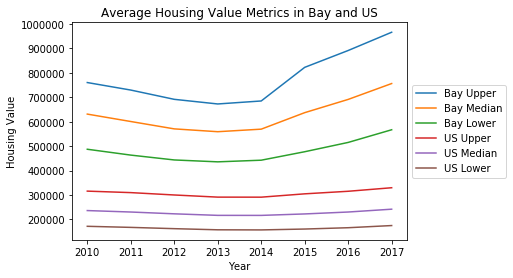

In [ ]:
fig, ax = plt.subplots()
plt.plot(intro_bay["year"], intro_bay["housing_value_upper"], label = 'Bay Upper')
plt.plot(intro_bay["year"], intro_bay["housing_value_median"], label = 'Bay Median')
plt.plot(intro_bay["year"], intro_bay["housing_value_lower"], label = 'Bay Lower')
plt.plot(intro_us["year"], intro_us["housing_value_upper"], label = 'US Upper')
plt.plot(intro_us["year"], intro_us["housing_value_median"], label = 'US Median')
plt.plot(intro_us["year"], intro_us["housing_value_lower"], label = 'US Lower')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.title("Average Housing Value Metrics in Bay and US")
plt.xlabel("Year")
plt.ylabel("Housing Value")

Even the average of lower value quartile housing value in the Bay is much higher than the US upper value quartile housing value. Additionally, from 2014-2017 there’s a steep increase in the housing value.

In [ ]:
%%bigquery --project $project_id rent_housingvalue_relative

SELECT
income_per_capita,
median_income,
median_rent,
owner_occupied_housing_units_median_value AS median_housing_value,
ROUND((median_rent / income_per_capita)*100,2) AS rent_relative_to_income,
ROUND((owner_occupied_housing_units_median_value / income_per_capita)*100,2) AS housing_value_relative_to_income
FROM
`cs145-proj3-final.cs145_proj3.censustract_concat_bay`

The following two figures further solidifed our decision to use Median Rent, Income Per Capita and Median Housing Value. Whereas for Housing Value, both Income Per Capita and Median Housing Value showed a strong positive correlation, there seemed to be a more complex relationship between rent and income per capita that we wanted to explore.

Text(0, 0.5, 'Median Rent')

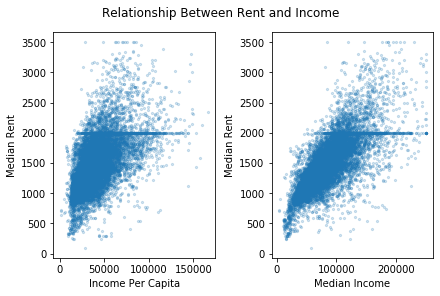

In [ ]:
fig, (ax1,ax2) = plt.subplots(1,2, constrained_layout=True)
fig.suptitle("Relationship Between Rent and Income Metrics")
ax1.scatter(rent_housingvalue_relative["income_per_capita"], rent_housingvalue_relative["median_rent"], s=5, alpha=0.2)
ax1.set_xlabel("Income Per Capita")
ax1.set_ylabel("Median Rent")
ax2.scatter(rent_housingvalue_relative["median_income"], rent_housingvalue_relative["median_rent"], s=5, alpha=0.2)
ax2.set_xlabel("Median Income")
ax2.set_ylabel("Median Rent")

Text(0, 0.5, 'Median Housing Value')

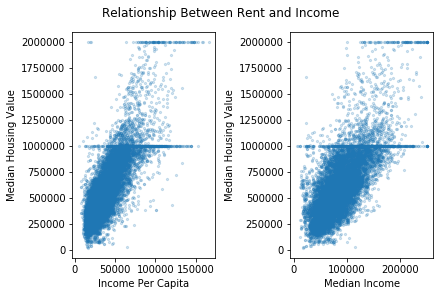

In [ ]:
fig, (ax1,ax2) = plt.subplots(1,2, constrained_layout=True)
fig.suptitle("Relationship Between Housing Value and Income Metrics")
ax1.scatter(rent_housingvalue_relative["income_per_capita"], rent_housingvalue_relative["median_housing_value"], s=5, alpha=0.2)
ax1.set_xlabel("Income Per Capita")
ax1.set_ylabel("Median Housing Value")
ax2.scatter(rent_housingvalue_relative["median_income"], rent_housingvalue_relative["median_housing_value"], s=5, alpha=0.2)
ax2.set_xlabel("Median Income")
ax2.set_ylabel("Median Housing Value")

Text(0, 0.5, 'Housing Value Relative to Income')

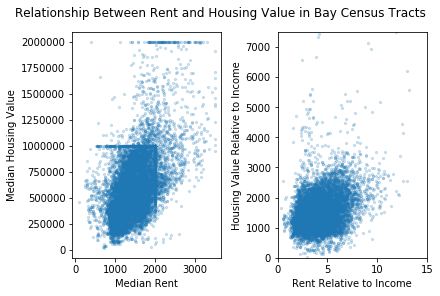

In [ ]:
fig, (ax1,ax2) = plt.subplots(1,2, constrained_layout=True)
fig.suptitle("Relationship Between Rent and Housing Value in Bay Census Tracts")
ax1.scatter(rent_housingvalue_relative["median_rent"], rent_housingvalue_relative["median_housing_value"], s=5, alpha=0.2)
ax1.set_xlabel("Median Rent")
ax1.set_ylabel("Median Housing Value")
ax2.scatter(rent_housingvalue_relative["rent_relative_to_income"], rent_housingvalue_relative["housing_value_relative_to_income"], s=5, alpha=0.2)
ax2.set_xlim([0,15])
ax2.set_ylim([0,7500])
ax2.set_xlabel("Rent Relative to Income")
ax2.set_ylabel("Housing Value Relative to Income")


After determining that we would use median rent, median housing value, and income per capita, we made the above visualizations to see how different the relationship between the rent and housing value in relation to income and purely rent and housing value. 

The relationship between the proportion of rent and housing value to income is more loosely correlated than the relationship between rent and housing value. The higher the median housing value in a census tract, it seemed the higher the median rent. However in introducing the income facet, this is less strong which can indicate that the incomes of people who own their homes and incomes of people who rent do not necessarily directly relate to the housing value and rent price. This would lean towards supporting the “house rich, cash poor” statement.

In [ ]:
%%bigquery --project $project_id year_own_rent

SELECT year, ROUND(AVG(median_rent / income_per_capita)*100,2) AS rent_relative_to_income,
  ROUND(AVG(owner_occupied_housing_units_median_value / income_per_capita)*100,2) AS housing_value_relative_to_income
FROM `cs145-proj3-final.cs145_proj3.censustract_concat_bay` 
WHERE median_rent IS NOT NULL AND owner_occupied_housing_units_median_value IS NOT NULL
GROUP BY year
ORDER BY year

In [ ]:
%%bigquery --project $project_id year_own_rent_us

SELECT year, ROUND(AVG(median_rent / income_per_capita)*100,2) AS rent_relative_to_income,
  ROUND(AVG(owner_occupied_housing_units_median_value / income_per_capita)*100,2) AS housing_value_relative_to_income
FROM `cs145-proj3-final.cs145_proj3.censustract_concat` 
WHERE median_rent IS NOT NULL AND owner_occupied_housing_units_median_value IS NOT NULL
GROUP BY year
ORDER BY year

Text(0, 0.5, 'Value of Home Relative to Income Per Capita')

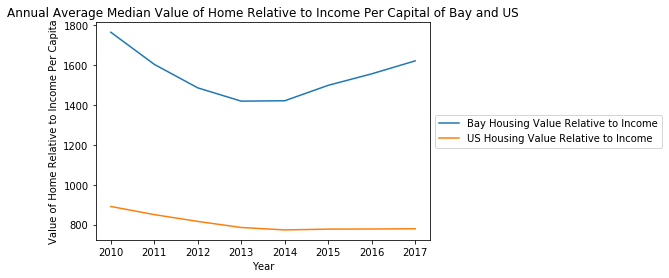

In [ ]:
fig, ax = plt.subplots()
plt.plot(year_own_rent["year"], year_own_rent["housing_value_relative_to_income"], label="Bay Housing Value Relative to Income")
plt.plot(year_own_rent_us["year"], year_own_rent_us["housing_value_relative_to_income"], label="US Housing Value Relative to Income")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.title("Annual Average Median Value of Home Relative to Income Per Capital of Bay and US")
plt.xlabel("Year")
plt.ylabel("Value of Home Relative to Income Per Capita")

The Bay Area housing value relative to income takes an interesting dip in the years 2013 and 2014. Visualizations above indicate that  income was pretty standard during those two years however, the housing value during that time is a transition point between 2010-2012 where housing value is slightly decreasing and 2014-2017 where housing value is steeply increasing. This likely accounts for the dip during those two years. The visualization accentuates the fact that the increase in income between 2014-2017 was substantial since  housing value relative to income shows a steeper decrease between 2010-2012 than the increase between 2014-2017 which is the opposite of this visualization. 

Text(0, 0.5, 'Rent Relative to Income Per Capita')

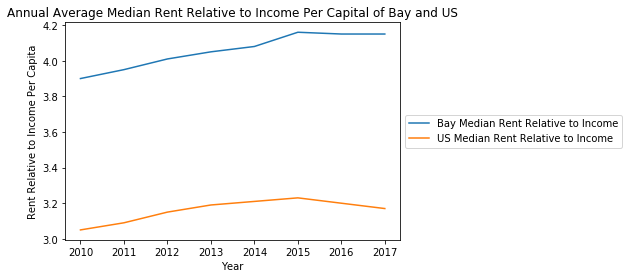

In [ ]:
fig, ax = plt.subplots()
plt.plot(year_own_rent["year"], year_own_rent["rent_relative_to_income"], label="Bay Median Rent Relative to Income")
plt.plot(year_own_rent_us["year"], year_own_rent_us["rent_relative_to_income"], label="US Median Rent Relative to Income")
plt.title("Annual Average Median Rent Relative to Income Per Capital of Bay and US")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.xlabel("Year")
plt.ylabel("Rent Relative to Income Per Capita")

This visualization shows that even rent makes up more of a persons income on average. The graph shows that a months rent is about 4.1% of the income in the 2016-2017 period which is equivalent to nearly 50% of someone’s annual income.

**Households with Families**

In [ ]:
%%bigquery --project $project_id family

SELECT
  ROUND((census.median_rent / census.income_per_capita)*100,2) AS rent_relative_to_income,
  ROUND((census.owner_occupied_housing_units_median_value / census.income_per_capita)*100,2) AS housing_value_relative_to_income,
  (census.nonfamily_households + census.family_households) AS total_households,
  ROUND((census.nonfamily_households / (census.nonfamily_households + census.family_households)) * 100,2) AS percent_nonfamily,
  ROUND((census.family_households / (census.nonfamily_households + census.family_households)) * 100,2) AS percent_family
FROM
  `cs145-proj3-final.cs145_proj3.censustract_concat_bay` census
WHERE
  (census.nonfamily_households != 0
    OR census.family_households != 0)
  AND census.median_rent / census.income_per_capita IS NOT NULL
   AND census.owner_occupied_housing_units_median_value / census.income_per_capita IS NOT NULL

Text(0, 0.5, 'rent_relative_to_income')

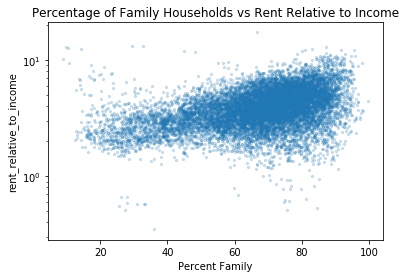

In [ ]:
fig, ax = plt.subplots()
plt.scatter(family["percent_family"], family["rent_relative_to_income"], s=5, alpha=0.2)
ax.set_yscale('log')
plt.title("Percentage of Family Households vs Rent Relative to Income")
plt.xlabel("Percent Family")
plt.ylabel("rent_relative_to_income")

This correlation graph indicates that the higher the percentage of families in a census tract, the higher the percentage monthly rent is of the income. This could be explained by the fact that there are likely more than one income earners in a family household whereas the income per capita only captures one person’s earnings. 

Text(0, 0.5, 'Housing Value Relative to Income')

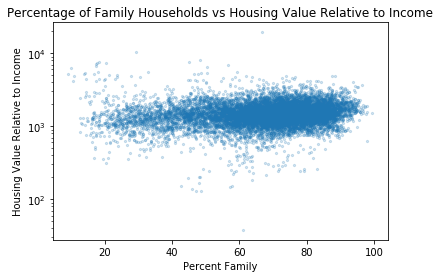

In [ ]:
fig, ax = plt.subplots()
plt.scatter(family["percent_family"], family["housing_value_relative_to_income"], s=5, alpha=0.2)
ax.set_yscale('log')
plt.title("Percentage of Family Households vs Housing Value Relative to Income")
plt.xlabel("Percent Family")
plt.ylabel("Housing Value Relative to Income")

Housing value relative to income doesn’t seem to really change depending on percent of family households in a census tract. On average it seems that housing value relative to income is around 1000%. 

**Construction Year of Buildings**

In [ ]:
%%bigquery --project $project_id year_built

SELECT
  ROUND((median_rent / income_per_capita)*100,2) AS rent_relative_to_income,
  ROUND((owner_occupied_housing_units_median_value / income_per_capita)*100,2) AS housing_value_relative_to_income,
  median_year_structure_built
FROM
  `cs145-proj3-final.cs145_proj3.censustract_concat_bay`
WHERE
  median_rent / income_per_capita IS NOT NULL
  AND owner_occupied_housing_units_median_value / income_per_capita IS NOT NULL
  AND median_year_structure_built IS NOT NULL

Text(0, 0.5, 'Rent Relative To Income')

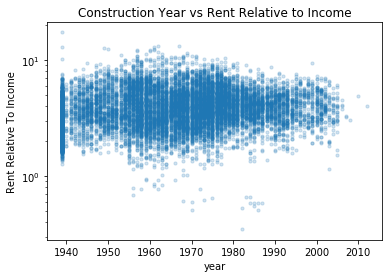

In [ ]:
fig, ax = plt.subplots()
plt.scatter(year_built["median_year_structure_built"], year_built["rent_relative_to_income"], s=10, alpha=0.2)
ax.set_yscale('log')
plt.title("Construction Year vs Rent Relative to Income")
plt.xlabel("year")
plt.ylabel("Rent Relative To Income")

This graph doesn’t seem to show any correlation between construction year of housing and rent relative to income. Regardless of whether housing is newer or not, there’s a wide range of percentage of income that rent takes up. This could indicate that quality of housing doesn’t necessarily get better in newer developments, or the quality of housing doesn’t have to necessarily correlate to the rent of the place. However we do see a slight tapering of the range of rents relative to income for the more recent median construction years which could indicate that areas with newer developments are owned by people and being inhabited by people who are more in agreement about the value of the housing.

Text(0, 0.5, 'Housing Value Relative to Income')

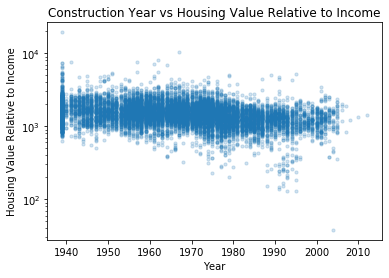

In [ ]:
fig, ax = plt.subplots()
plt.scatter(year_built["median_year_structure_built"], year_built["housing_value_relative_to_income"], s=10, alpha=0.2)
ax.set_yscale('log')
plt.title("Construction Year vs Housing Value Relative to Income")
plt.xlabel("Year")
plt.ylabel("Housing Value Relative to Income")

Construction year has a slight negative correlation with housing value relative to income. Houses generally depreciate in value, the older they are which could explain this. 

**Housing Ownership**

In [ ]:
%%bigquery --project $project_id percent_rent_vs_own

SELECT
  year,
  geo_id,
  nonfamily_households + family_households AS total_households,
  ROUND((owner_occupied_housing_units/ (nonfamily_households + family_households)) * 100, 2) AS percent_own,
  ROUND(((nonfamily_households + family_households - owner_occupied_housing_units)/ (nonfamily_households + family_households)) * 100, 2) AS percent_rent,
  ROUND((median_rent / income_per_capita)*100,2) AS rent_relative_to_income,
  ROUND((owner_occupied_housing_units_median_value / income_per_capita)*100,2) AS housing_value_relative_to_income
FROM
  `cs145-proj3-final.cs145_proj3.censustract_concat_bay`
WHERE
  median_rent IS NOT NULL
  AND income_per_capita IS NOT NULL
  AND owner_occupied_housing_units_median_value IS NOT NULL

Text(0, 0.5, 'Rent Relative to Income Per Capita')

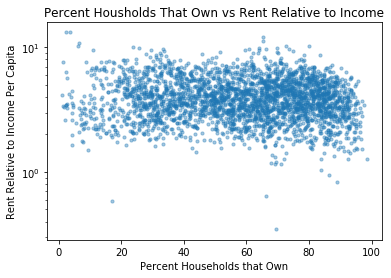

In [ ]:
samp = percent_rent_vs_own.sample(3000)
fig, ax = plt.subplots()
plt.scatter(samp["percent_own"], samp["rent_relative_to_income"], s=10, alpha=0.4)
ax.set_yscale('log')
plt.title("Percent Housholds That Own vs Rent Relative to Income")
plt.xlabel("Percent Households that Own")
plt.ylabel("Rent Relative to Income Per Capita")

This does not seem to show any trends.

Text(0, 0.5, 'Housing Value Relative to Income Per Capita')

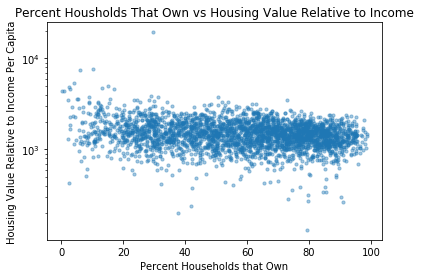

In [ ]:
samp = percent_rent_vs_own.sample(3000)
fig, ax = plt.subplots()
plt.scatter(samp["percent_own"], samp["housing_value_relative_to_income"], s=10, alpha=0.4)
ax.set_yscale('log')
plt.title("Percent Housholds That Own vs Housing Value Relative to Income")
plt.xlabel("Percent Households that Own")
plt.ylabel("Housing Value Relative to Income Per Capita")

This also doesn't seem to indicate any positive or negative correlation. It's fairly even across percent of households that own their home.

**County-wise Exploration**

In [ ]:
%%bigquery --project $project_id percent_rent_vs_own_alameda

SELECT year, AVG(percent_own) AS avg_percent_own, AVG(percent_rent) AS avg_percent_rent, AVG(rent_relative_to_income) AS avg_rent_relative_to_income, AVG(home_value_relative_to_income) AS avg_home_value_relative_to_income
FROM `cs145-proj3-final.cs145_proj3.rent_vs_own_bay`
WHERE geo_id LIKE '06001%'
GROUP BY year
ORDER BY year

In [ ]:
%%bigquery --project $project_id percent_rent_vs_own_contracosta

SELECT
  year,
  AVG(percent_own) AS avg_percent_own,
  AVG(percent_rent) AS avg_percent_rent,
  AVG(rent_relative_to_income) AS avg_rent_relative_to_income,
  AVG(home_value_relative_to_income) AS avg_home_value_relative_to_income
FROM
  `cs145-proj3-final.cs145_proj3.rent_vs_own_bay`
WHERE
  geo_id LIKE '06013%'
GROUP BY
  year
ORDER BY
  year

In [ ]:
%%bigquery --project $project_id percent_rent_vs_own_marin

SELECT
  year,
  AVG(percent_own) AS avg_percent_own,
  AVG(percent_rent) AS avg_percent_rent,
  AVG(rent_relative_to_income) AS avg_rent_relative_to_income,
  AVG(home_value_relative_to_income) AS avg_home_value_relative_to_income
FROM
  `cs145-proj3-final.cs145_proj3.rent_vs_own_bay`
WHERE
  geo_id LIKE '06041%'
GROUP BY
  year
ORDER BY
  year

In [ ]:
%%bigquery --project $project_id percent_rent_vs_own_napa

SELECT
  year,
  AVG(percent_own) AS avg_percent_own,
  AVG(percent_rent) AS avg_percent_rent,
  AVG(rent_relative_to_income) AS avg_rent_relative_to_income,
  AVG(home_value_relative_to_income) AS avg_home_value_relative_to_income
FROM
  `cs145-proj3-final.cs145_proj3.rent_vs_own_bay`
WHERE
  geo_id LIKE '06055%'
GROUP BY
  year
ORDER BY
  year

In [ ]:
%%bigquery --project $project_id percent_rent_vs_own_sf

SELECT
  year,
  AVG(percent_own) AS avg_percent_own,
  AVG(percent_rent) AS avg_percent_rent,
  AVG(rent_relative_to_income) AS avg_rent_relative_to_income,
  AVG(home_value_relative_to_income) AS avg_home_value_relative_to_income
FROM
  `cs145-proj3-final.cs145_proj3.rent_vs_own_bay`
WHERE
  geo_id LIKE '06075%'
GROUP BY
  year
ORDER BY
  year

In [ ]:
%%bigquery --project $project_id percent_rent_vs_own_sanmateo

SELECT
  year,
  AVG(percent_own) AS avg_percent_own,
  AVG(percent_rent) AS avg_percent_rent,
  AVG(rent_relative_to_income) AS avg_rent_relative_to_income,
  AVG(home_value_relative_to_income) AS avg_home_value_relative_to_income
FROM
  `cs145-proj3-final.cs145_proj3.rent_vs_own_bay`
WHERE
  geo_id LIKE '06081%'
GROUP BY
  year
ORDER BY
  year

In [ ]:
%%bigquery --project $project_id percent_rent_vs_own_santaclara

SELECT
  year,
  AVG(percent_own) AS avg_percent_own,
  AVG(percent_rent) AS avg_percent_rent,
  AVG(rent_relative_to_income) AS avg_rent_relative_to_income,
  AVG(home_value_relative_to_income) AS avg_home_value_relative_to_income
FROM
  `cs145-proj3-final.cs145_proj3.rent_vs_own_bay`
WHERE
  geo_id LIKE '06085%'
GROUP BY
  year
ORDER BY
  year

In [ ]:
%%bigquery --project $project_id percent_rent_vs_own_solano

SELECT
  year,
  AVG(percent_own) AS avg_percent_own,
  AVG(percent_rent) AS avg_percent_rent,
  AVG(rent_relative_to_income) AS avg_rent_relative_to_income,
  AVG(home_value_relative_to_income) AS avg_home_value_relative_to_income
FROM
  `cs145-proj3-final.cs145_proj3.rent_vs_own_bay`
WHERE
  geo_id LIKE '06095%'
GROUP BY
  year
ORDER BY
  year

In [ ]:
%%bigquery --project $project_id percent_rent_vs_own_sonoma

SELECT
  year,
  AVG(percent_own) AS avg_percent_own,
  AVG(percent_rent) AS avg_percent_rent,
  AVG(rent_relative_to_income) AS avg_rent_relative_to_income,
  AVG(home_value_relative_to_income) AS avg_home_value_relative_to_income
FROM
  `cs145-proj3-final.cs145_proj3.rent_vs_own_bay`
WHERE
  geo_id LIKE '06097%'
GROUP BY
  year
ORDER BY
  year

Text(0, 0.5, 'Percent of Households that Own Home')

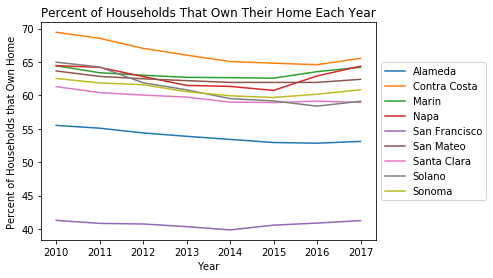

In [ ]:
fig, ax = plt.subplots()
plt.plot(percent_rent_vs_own_alameda["year"], percent_rent_vs_own_alameda["avg_percent_own"], label='Alameda')
plt.plot(percent_rent_vs_own_contracosta["year"], percent_rent_vs_own_contracosta["avg_percent_own"], label='Contra Costa')
plt.plot(percent_rent_vs_own_marin["year"], percent_rent_vs_own_marin["avg_percent_own"], label='Marin')
plt.plot(percent_rent_vs_own_napa["year"], percent_rent_vs_own_napa["avg_percent_own"], label='Napa')
plt.plot(percent_rent_vs_own_sf["year"], percent_rent_vs_own_sf["avg_percent_own"],label='San Francisco')
plt.plot(percent_rent_vs_own_sanmateo["year"], percent_rent_vs_own_sanmateo["avg_percent_own"], label='San Mateo')
plt.plot(percent_rent_vs_own_santaclara["year"], percent_rent_vs_own_santaclara["avg_percent_own"], label='Santa Clara')
plt.plot(percent_rent_vs_own_solano["year"], percent_rent_vs_own_solano["avg_percent_own"], label='Solano')
plt.plot(percent_rent_vs_own_sonoma["year"], percent_rent_vs_own_sonoma["avg_percent_own"], label='Sonoma')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.title("Percent of Households That Own Their Home Each Year")
plt.xlabel("Year")
plt.ylabel("Percent of Households that Own Home")

This visualization helped to look at the county trends and helps to set up the anlaysis of the graphs below. San Francisco is the more extreme outlier of the 9 countie on home ownership which makes sense as an more urban area.

Text(0, 0.5, 'Average Home Value Relative to Income')

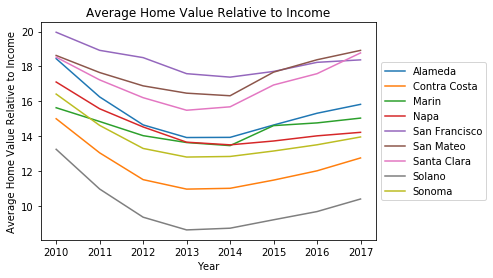

In [ ]:
fig, ax = plt.subplots()
plt.plot(percent_rent_vs_own_alameda["year"], percent_rent_vs_own_alameda["avg_home_value_relative_to_income"], label='Alameda')
plt.plot(percent_rent_vs_own_contracosta["year"], percent_rent_vs_own_contracosta["avg_home_value_relative_to_income"], label='Contra Costa')
plt.plot(percent_rent_vs_own_marin["year"], percent_rent_vs_own_marin["avg_home_value_relative_to_income"], label='Marin')
plt.plot(percent_rent_vs_own_napa["year"], percent_rent_vs_own_napa["avg_home_value_relative_to_income"],  label='Napa')
plt.plot(percent_rent_vs_own_sf["year"], percent_rent_vs_own_sf["avg_home_value_relative_to_income"],  label='San Francisco')
plt.plot(percent_rent_vs_own_sanmateo["year"], percent_rent_vs_own_sanmateo["avg_home_value_relative_to_income"],  label='San Mateo')
plt.plot(percent_rent_vs_own_santaclara["year"], percent_rent_vs_own_santaclara["avg_home_value_relative_to_income"],  label='Santa Clara')
plt.plot(percent_rent_vs_own_solano["year"], percent_rent_vs_own_solano["avg_home_value_relative_to_income"], label='Solano')
plt.plot(percent_rent_vs_own_sonoma["year"], percent_rent_vs_own_sonoma["avg_home_value_relative_to_income"], label='Sonoma')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.title("Average Home Value Relative to Income")
plt.xlabel("Year")
plt.ylabel("Average Home Value Relative to Income")

The following two graphs shows home value and rent relative to income trends for each county. An interesting note is that Solano has the lowerst home value relative to income and the highest rent relative to income. This means the rental market is a lot tougher in Solano but the interest in more permanent purchase of property in Solano is not as high as in other counties.

Text(0, 0.5, 'Average Rent Relative to Income')

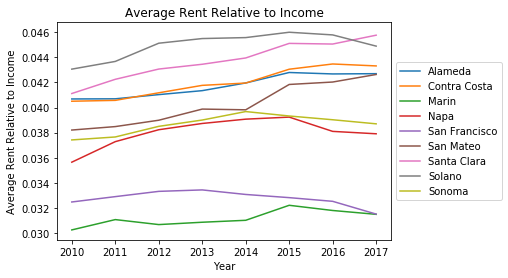

In [ ]:
fig, ax = plt.subplots()
plt.plot(percent_rent_vs_own_alameda["year"], percent_rent_vs_own_alameda["avg_rent_relative_to_income"],  label='Alameda')
plt.plot(percent_rent_vs_own_contracosta["year"], percent_rent_vs_own_contracosta["avg_rent_relative_to_income"],  label='Contra Costa')
plt.plot(percent_rent_vs_own_marin["year"], percent_rent_vs_own_marin["avg_rent_relative_to_income"], label='Marin')
plt.plot(percent_rent_vs_own_napa["year"], percent_rent_vs_own_napa["avg_rent_relative_to_income"], label='Napa')
plt.plot(percent_rent_vs_own_sf["year"], percent_rent_vs_own_sf["avg_rent_relative_to_income"],  label='San Francisco')
plt.plot(percent_rent_vs_own_sanmateo["year"], percent_rent_vs_own_sanmateo["avg_rent_relative_to_income"], label='San Mateo')
plt.plot(percent_rent_vs_own_santaclara["year"], percent_rent_vs_own_santaclara["avg_rent_relative_to_income"],  label='Santa Clara')
plt.plot(percent_rent_vs_own_solano["year"], percent_rent_vs_own_solano["avg_rent_relative_to_income"],  label='Solano')
plt.plot(percent_rent_vs_own_sonoma["year"], percent_rent_vs_own_sonoma["avg_rent_relative_to_income"],  label='Sonoma')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.title("Average Rent Relative to Income")
plt.xlabel("Year")
plt.ylabel("Average Rent Relative to Income")

In [ ]:
%%bigquery --project $project_id county

SELECT
  CASE
    WHEN geo_id LIKE '06001%' THEN 'Alameda'
    WHEN geo_id LIKE '06013%' THEN 'Contra Costa'
    WHEN geo_id LIKE '06041%' THEN 'Marin'
    WHEN geo_id LIKE '06055%' THEN 'Napa'
    WHEN geo_id LIKE '06075%' THEN 'San Francisco'
    WHEN geo_id LIKE '06081%' THEN 'San Mateo'
    WHEN geo_id LIKE '06085%' THEN 'Santa Clara'
    WHEN geo_id LIKE '06095%' THEN 'Solano'
    WHEN geo_id LIKE '06097%' THEN 'Sonoma'
END
  AS county,
  median_rent,
  owner_occupied_housing_units_median_value AS median_housing_value,
  ROUND((median_rent / income_per_capita)*100,2) AS rent_relative_to_income,
  ROUND((owner_occupied_housing_units_median_value / income_per_capita)*100,2) AS housing_value_relative_to_income
FROM
  `cs145-proj3-final.cs145_proj3.censustract_concat_bay`
WHERE
  median_rent IS NOT NULL
  AND owner_occupied_housing_units_median_value IS NOT NULL

In [ ]:
%%bigquery --project $project_id county_avg

SELECT
  CASE
    WHEN geo_id LIKE '06001%' THEN 'Alameda'
    WHEN geo_id LIKE '06013%' THEN 'Contra Costa'
    WHEN geo_id LIKE '06041%' THEN 'Marin'
    WHEN geo_id LIKE '06055%' THEN 'Napa'
    WHEN geo_id LIKE '06075%' THEN 'San Francisco'
    WHEN geo_id LIKE '06081%' THEN 'San Mateo'
    WHEN geo_id LIKE '06085%' THEN 'Santa Clara'
    WHEN geo_id LIKE '06095%' THEN 'Solano'
    WHEN geo_id LIKE '06097%' THEN 'Sonoma'
END
  AS county,
  AVG(ROUND((median_rent / income_per_capita)*100,2)) AS rent_relative_to_income,
  AVG(ROUND((owner_occupied_housing_units_median_value / income_per_capita)*100,2)) AS housing_value_relative_to_income
FROM
  `cs145-proj3-final.cs145_proj3.censustract_concat_bay`
WHERE
  median_rent IS NOT NULL
  AND owner_occupied_housing_units_median_value IS NOT NULL
  GROUP BY county

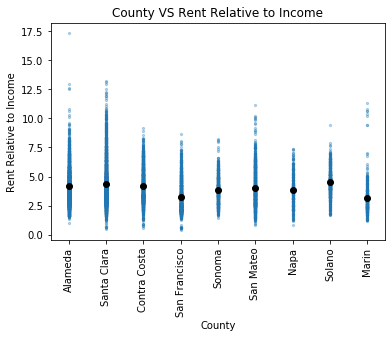

In [ ]:
fig, ax1 = plt.subplots()
plt.scatter(county["county"], county["rent_relative_to_income"], s=5, alpha=0.3)
plt.title("County VS Rent Relative to Income")
plt.xlabel("County")
plt.xticks(rotation="90")
ax1.set_ylabel("Rent Relative to Income")
ax1.scatter(county_avg["county"],county_avg["rent_relative_to_income"],color="BLACK")


The range especially the upper bound for rent relative to income varies from county to county. 

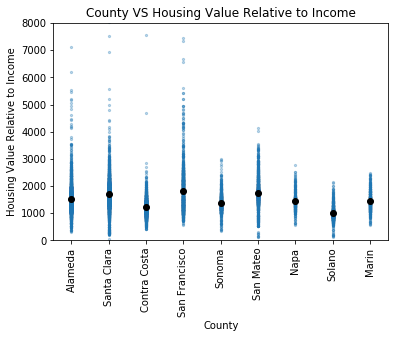

In [ ]:
fig, ax1 = plt.subplots()
plt.scatter(county["county"], county["housing_value_relative_to_income"], s=5, alpha=0.3)
plt.title("County VS Housing Value Relative to Income")
plt.xlabel("County")
plt.xticks(rotation="90")
plt.ylim([0,8000])
ax1.set_ylabel("Housing Value Relative to Income")
ax1.scatter(county_avg["county"],county_avg["housing_value_relative_to_income"],color="BLACK")

Similar to rent relative to income, housing value relative to income ranges dramatically for the upper bound amongst the counties.

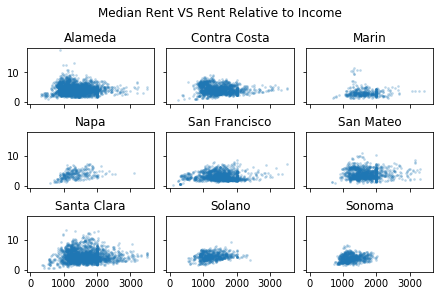

In [ ]:
fig, ax = plt.subplots(3,3, sharex=True, sharey=True, constrained_layout=True)
fig.suptitle("Median Rent VS Rent Relative to Income")
alameda = county.loc[county['county']=="Alameda"]
contra = county.loc[county['county']=="Contra Costa"]
marin = county.loc[county['county']=="Marin"]
napa = county.loc[county['county']=="Napa"]
sf = county.loc[county['county']=="San Francisco"]
sanmateo = county.loc[county['county']=="San Mateo"]
santaclara = county.loc[county['county']=="Santa Clara"]
solano = county.loc[county['county']=="Solano"]
sonoma = county.loc[county['county']=="Sonoma"]
ax[0,0].set_title('Alameda')
ax[0,0].scatter(alameda["median_rent"],alameda["rent_relative_to_income"], s=3, alpha =0.2)
ax[0,1].set_title('Contra Costa')
ax[0,1].scatter(contra["median_rent"],contra["rent_relative_to_income"], s=3, alpha =0.2)
ax[0,2].set_title('Marin')
ax[0,2].scatter(marin["median_rent"],marin["rent_relative_to_income"], s=3, alpha =0.2)
ax[1,0].set_title('Napa')
ax[1,0].scatter(napa["median_rent"],napa["rent_relative_to_income"], s=3, alpha =0.2)
ax[1,1].set_title('San Francisco')
ax[1,1].scatter(sf["median_rent"],sf["rent_relative_to_income"], s=3, alpha =0.2)
ax[1,2].set_title('San Mateo')
ax[1,2].scatter(sanmateo["median_rent"],sanmateo["rent_relative_to_income"], s=3, alpha =0.2)
ax[2,0].set_title('Santa Clara')
ax[2,0].scatter(santaclara["median_rent"],santaclara["rent_relative_to_income"], s=3, alpha =0.2)
ax[2,1].set_title('Solano')
ax[2,1].scatter(solano["median_rent"],solano["rent_relative_to_income"], s=3, alpha =0.2)
ax[2,2].set_title('Sonoma')
ax[2,2].scatter(sonoma["median_rent"],sonoma["rent_relative_to_income"], s=3, alpha =0.2)
for ax in fig.get_axes():
    ax.label_outer()

This visualization further exemplifies the different demographics between the counties. Whereas Santa Clara covers a wide range of median rents and rents relative to income, Sonoma and Solano have a smaller range of median rents and rents relative to income. 

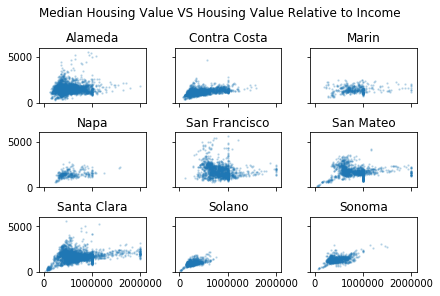

In [ ]:
fig, ax = plt.subplots(3,3, sharex=True, sharey=True, constrained_layout=True)
fig.suptitle("Median Housing Value VS Housing Value Relative to Income")
alameda = county.loc[county['county']=="Alameda"]
contra = county.loc[county['county']=="Contra Costa"]
marin = county.loc[county['county']=="Marin"]
napa = county.loc[county['county']=="Napa"]
sf = county.loc[county['county']=="San Francisco"]
sanmateo = county.loc[county['county']=="San Mateo"]
santaclara = county.loc[county['county']=="Santa Clara"]
solano = county.loc[county['county']=="Solano"]
sonoma = county.loc[county['county']=="Sonoma"]
ax[0,0].set_title('Alameda')
ax[0,0].scatter(alameda["median_housing_value"],alameda["housing_value_relative_to_income"], s=2, alpha =0.2)
ax[0,1].set_title('Contra Costa')
ax[0,1].scatter(contra["median_housing_value"],contra["housing_value_relative_to_income"], s=2, alpha =0.2)
ax[0,2].set_title('Marin')
ax[0,2].scatter(marin["median_housing_value"],marin["housing_value_relative_to_income"], s=2, alpha =0.2)
ax[1,0].set_title('Napa')
ax[1,0].scatter(napa["median_housing_value"],napa["housing_value_relative_to_income"], s=2, alpha =0.2)
ax[1,1].set_title('San Francisco')
ax[1,1].scatter(sf["median_housing_value"],sf["housing_value_relative_to_income"], s=2, alpha =0.2)
ax[1,2].set_title('San Mateo')
ax[1,2].scatter(sanmateo["median_housing_value"],sanmateo["housing_value_relative_to_income"], s=2, alpha =0.2)
ax[2,0].set_title('Santa Clara')
ax[2,0].scatter(santaclara["median_housing_value"],santaclara["housing_value_relative_to_income"], s=2, alpha =0.2)
ax[2,1].set_title('Solano')
ax[2,1].scatter(solano["median_housing_value"],solano["housing_value_relative_to_income"], s=2, alpha =0.2)
ax[2,2].set_title('Sonoma')
ax[2,2].scatter(sonoma["median_housing_value"],sonoma["housing_value_relative_to_income"], s=2, alpha =0.2)
for ax in fig.get_axes():
    ax.set_ylim([0,6000])
    ax.label_outer()


Similar to the rent visualization above, this visualization exemplifies the different behaviros in the counties. There also seems to be a trend where there is a correlation of steep increase of housing values relative to income as median housing value increases that is at the lower range of housing values and a less steep correlation set that has a wider range of housing values. This would strongly indicate the "house rich, cash poor" phrase. The set of smaller housing values that have high housing value relative to income indicates the set of homeowners who own a home that increase in value but their income has not increased wiht the value for their home. It makes sense that this steep correlation is concentrated in the lower housing value census tracts.  

**Gender**

In [ ]:
%%bigquery --project $project_id gender_temporal

SELECT
  year,
  ROUND(AVG(median_rent / income_per_capita)*100, 2) AS rent_relative_to_income,
  ROUND(AVG(owner_occupied_housing_units_median_value / income_per_capita)*100, 2) AS housing_value_relative_to_income,
  ROUND(AVG(female_pop / total_pop)*100,2) AS percent_female,
  ROUND(AVG(male_pop / total_pop)*100,2) AS percent_male
FROM
  `cs145-proj3-final.cs145_proj3.censustract_concat_bay`
WHERE total_pop > 0 AND median_rent IS NOT NULL AND owner_occupied_housing_units_median_value IS NOT NULL
GROUP BY
  year
ORDER BY
  year

Text(0.5, 0, 'Year')

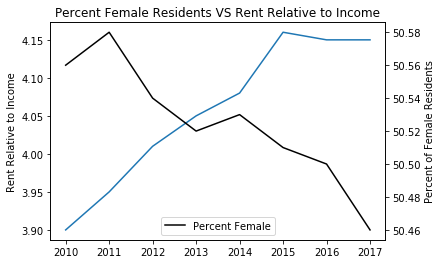

In [ ]:
fig, ax = plt.subplots()
ax.plot(gender_temporal["year"], gender_temporal["rent_relative_to_income"], label="Rent Relative to Income")
ax2 = ax.twinx()
ax2.plot(gender_temporal["year"], gender_temporal["percent_female"], label="Percent Female", color="BLACK")
plt.title("Percent Female Residents VS Rent Relative to Income")
ax.set_ylabel("Rent Relative to Income")
ax2.set_ylabel("Percent of Female Residents")
plt.legend(loc='lower center')
plt.xlabel("Year")

This indicates that there is likely no correlation between the gneder distribution and rent relative to income. The percent of female residents is ever so slightly decreasing likely to general population changes. 

Text(0.5, 0, 'Year')

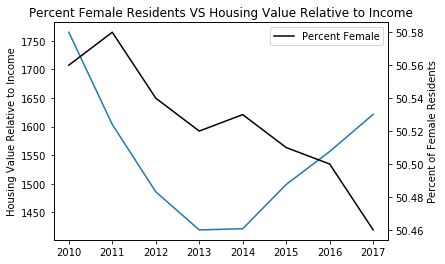

In [ ]:
fig, ax = plt.subplots()
ax.plot(gender_temporal["year"], gender_temporal["housing_value_relative_to_income"], label="Rent Relative to Income")
ax2 = ax.twinx()
ax2.plot(gender_temporal["year"], gender_temporal["percent_female"], label="Percent Female", color="BLACK")
plt.title("Percent Female Residents VS Housing Value Relative to Income")
ax.set_ylabel("Housing Value Relative to Income")
ax2.set_ylabel("Percent of Female Residents")
plt.legend(loc='upper right')
plt.xlabel("Year")


In [ ]:
%%bigquery --project $project_id gender

SELECT
  ROUND((median_rent / income_per_capita)*100,2) AS rent_relative_to_income,
  ROUND((owner_occupied_housing_units_median_value / income_per_capita)*100,2) AS housing_value_relative_to_income,
  ROUND((female_pop / total_pop)*100,2) AS percent_female,
  ROUND((male_pop / total_pop)*100,2) AS percent_male
FROM
  `cs145-proj3-final.cs145_proj3.censustract_concat_bay`
WHERE total_pop > 0 AND median_rent IS NOT NULL AND owner_occupied_housing_units_median_value IS NOT NULL

Text(0, 0.5, 'Housing Value Relative to Income')

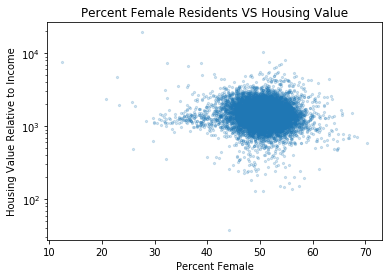

In [ ]:
fig, ax = plt.subplots()
plt.scatter(gender["percent_female"], gender["housing_value_relative_to_income"], s=5, alpha=0.2)
plt.title("Percent Female Residents VS Housing Value")
plt.yscale("log")
plt.xlabel("Percent Female")
plt.ylabel("Housing Value Relative to Income")

As the graphs above indicated, this graph further suggests there is not a correlation between gender and housing value relative to income.

Text(0, 0.5, 'Rent Relative to Income')

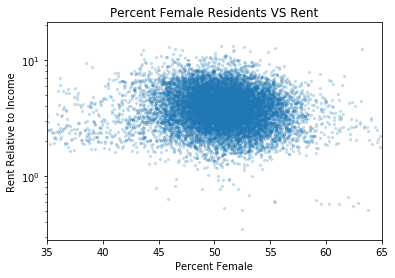

In [ ]:
fig, ax = plt.subplots()
plt.scatter(gender["percent_female"], gender["rent_relative_to_income"], s=5, alpha=0.2)
plt.title("Percent Female Residents VS Rent")
plt.yscale("log")
ax.set_xlim([35,65])
plt.xlabel("Percent Female")
plt.ylabel("Rent Relative to Income")

As the graphs above indicated, this graph further suggests there is not a correlation between gender and rent relative to income.

**Migration**

The dataset provides us with two data points, number of people in the census tract who had moved in within the past year who moved in from a different city and number of people who moved in from the same city. We used these two to calculate the total people who had moved in the past year.

The following two graphs which disaggregate household migration in Bay by county.

In [ ]:
%%bigquery --project $project_id migration

SELECT
  CASE
    WHEN geo_id LIKE '06001%' THEN 'Alameda'
    WHEN geo_id LIKE '06013%' THEN 'Contra Costa'
    WHEN geo_id LIKE '06041%' THEN 'Marin'
    WHEN geo_id LIKE '06055%' THEN 'Napa'
    WHEN geo_id LIKE '06075%' THEN 'San Francisco'
    WHEN geo_id LIKE '06081%' THEN 'San Mateo'
    WHEN geo_id LIKE '06085%' THEN 'Santa Clara'
    WHEN geo_id LIKE '06095%' THEN 'Solano'
    WHEN geo_id LIKE '06097%' THEN 'Sonoma'
END AS county
  ,
  year,
  ROUND(AVG((median_rent / income_per_capita)), 4) AS rent_relative_to_income,
  ROUND(AVG(owner_occupied_housing_units_median_value / income_per_capita), 4) AS house_pricerelative_to_income,
  ROUND(AVG(different_house_year_ago_different_city / total_pop)*100,2) AS diff_city,
  ROUND(AVG(different_house_year_ago_same_city / total_pop)*100,2) AS same_city,
  ROUND(AVG((different_house_year_ago_different_city + different_house_year_ago_same_city) / total_pop)*100,2) AS total_diff_house,
  ROUND(AVG((different_house_year_ago_different_city - different_house_year_ago_same_city)/total_pop)*100,2) AS compare
FROM
  `cs145-proj3-final.cs145_proj3.censustract_concat_bay`
WHERE
  median_rent IS NOT NULL
  AND owner_occupied_housing_units_median_value IS NOT NULL
GROUP BY
county
  ,
  year
ORDER BY 
  year

Text(0, 0.5, 'Percent of Households Who Moved Houses')

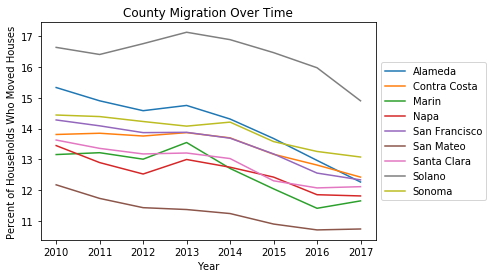

In [ ]:
fig, ax = plt.subplots()
alameda = migration.loc[migration['county']=="Alameda"]
contra = migration.loc[migration['county']=="Contra Costa"]
marin = migration.loc[migration['county']=="Marin"]
napa = migration.loc[migration['county']=="Napa"]
sf = migration.loc[migration['county']=="San Francisco"]
sanmateo = migration.loc[migration['county']=="San Mateo"]
santaclara = migration.loc[migration['county']=="Santa Clara"]
solano = migration.loc[migration['county']=="Solano"]
sonoma = migration.loc[migration['county']=="Sonoma"]
plt.plot(alameda["year"], alameda["total_diff_house"],  label='Alameda')
plt.plot(contra["year"], contra["total_diff_house"],  label='Contra Costa')
plt.plot(marin["year"], marin["total_diff_house"],  label='Marin')
plt.plot(napa["year"], napa["total_diff_house"],  label='Napa')
plt.plot(sf["year"], sf["total_diff_house"],  label='San Francisco')
plt.plot(sanmateo["year"], sanmateo["total_diff_house"],  label='San Mateo')
plt.plot(santaclara["year"], santaclara["total_diff_house"],  label='Santa Clara')
plt.plot(solano["year"], solano["total_diff_house"],  label='Solano')
plt.plot(sonoma["year"], sonoma["total_diff_house"],  label='Sonoma')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.title("County Migration Over Time")
plt.xlabel("Year")
plt.ylabel("Percent of Households Who Moved Houses")

Text(0, 0.5, 'Percent of Households')

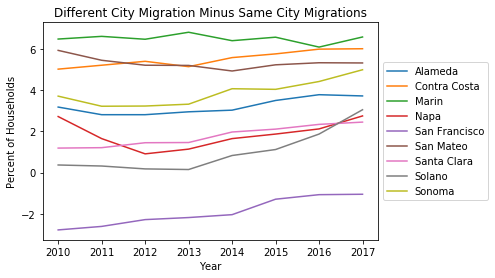

In [ ]:
fig, ax = plt.subplots()
alameda = migration.loc[migration['county']=="Alameda"]
contra = migration.loc[migration['county']=="Contra Costa"]
marin = migration.loc[migration['county']=="Marin"]
napa = migration.loc[migration['county']=="Napa"]
sf = migration.loc[migration['county']=="San Francisco"]
sanmateo = migration.loc[migration['county']=="San Mateo"]
santaclara = migration.loc[migration['county']=="Santa Clara"]
solano = migration.loc[migration['county']=="Solano"]
sonoma = migration.loc[migration['county']=="Sonoma"]
plt.plot(alameda["year"], alameda["compare"],  label='Alameda')
plt.plot(contra["year"], contra["compare"],  label='Contra Costa')
plt.plot(marin["year"], marin["compare"],  label='Marin')
plt.plot(napa["year"], napa["compare"], label='Napa')
plt.plot(sf["year"], sf["compare"],  label='San Francisco')
plt.plot(sanmateo["year"], sanmateo["compare"],  label='San Mateo')
plt.plot(santaclara["year"], santaclara["compare"],  label='Santa Clara')
plt.plot(solano["year"], solano["compare"], label='Solano')
plt.plot(sonoma["year"], sonoma["compare"], label='Sonoma')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.title("Different City Migration Minus Same City Migrations")
plt.xlabel("Year")
plt.ylabel("Percent of Households")

Unlike the other counties where mostly people moved from a differnet city in, for San Francisco more people moved from the same city which means people in the city generally are staying in the city. 

In [ ]:
%%bigquery --project $project_id migration_all

SELECT
   ROUND((median_rent / income_per_capita)*100,2) AS rent_relative_to_income,
  ROUND((owner_occupied_housing_units_median_value / income_per_capita)*100,2) AS housing_value_relative_to_income,
  ROUND((different_house_year_ago_different_city / total_pop)*100,2) AS diff_city,
  ROUND((different_house_year_ago_same_city / total_pop)*100,2) AS same_city,
  ROUND(((different_house_year_ago_different_city + different_house_year_ago_same_city) / total_pop)*100,2) AS total_diff_house,
  ROUND(((different_house_year_ago_different_city - different_house_year_ago_same_city)/total_pop)*100,2) AS compare
FROM
  `cs145-proj3-final.cs145_proj3.censustract_concat_bay`
WHERE
  median_rent IS NOT NULL
  AND owner_occupied_housing_units_median_value IS NOT NULL


Text(0, 0.5, 'Rent Relative to Income')

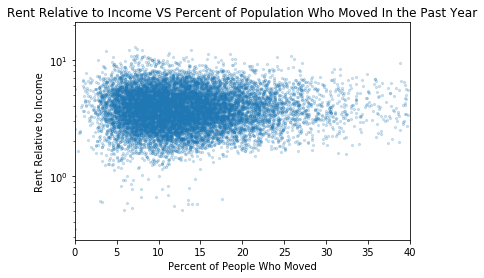

In [ ]:
fig, ax = plt.subplots()
plt.scatter(migration_all["total_diff_house"], migration_all["rent_relative_to_income"], s=5, alpha=0.2, label='Percent of Households Who Moved Houses')
plt.title("Rent Relative to Income VS Percent of Population Who Moved In the Past Year")
plt.yscale("log")
plt.xlim([0,40])
plt.xlabel("Percent of People Who Moved")
plt.ylabel("Rent Relative to Income")

There is no correlation between people who moved to rent relative to income.

Text(0, 0.5, 'Rent Relative to Income')

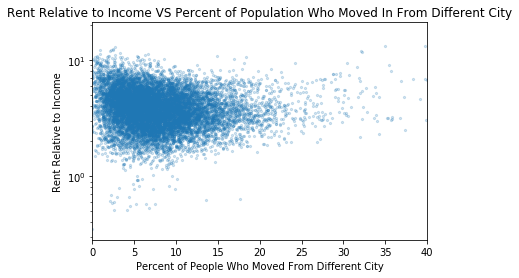

In [ ]:
fig, ax = plt.subplots()
plt.scatter(migration_all["diff_city"], migration_all["rent_relative_to_income"], s=5, alpha=0.2, label='Percent of Households Who Moved Houses')
plt.title("Rent Relative to Income VS Percent of Population Who Moved In From Different City")
plt.yscale("log")
plt.xlim([0,40])
plt.xlabel("Percent of People Who Moved From Different City")
plt.ylabel("Rent Relative to Income")

There does not seem to be a clear correlation, however there is a tapering for the range of rent relative to income as there is more and more people who moved in from a different city. This might be the case because as seen above, mostly all counties besides the very urban San Francisco have more people moving in from a different city. It's likely that these are people of a certain standard of living. 

Text(0, 0.5, 'Rent Relative to Income')

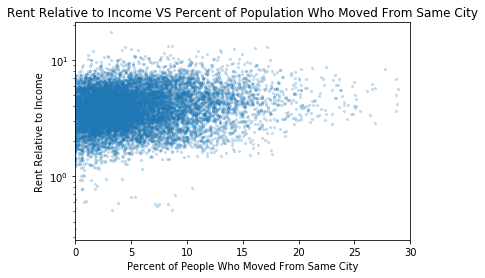

In [ ]:
fig, ax = plt.subplots()
plt.scatter(migration_all["same_city"], migration_all["rent_relative_to_income"], s=5, alpha=0.2, label='Percent of Households Who Moved Houses')
plt.title("Rent Relative to Income VS Percent of Population Who Moved From Same City")
plt.yscale("log")
plt.yscale("log")
plt.xlim([0,30])
plt.xlabel("Percent of People Who Moved From Same City")
plt.ylabel("Rent Relative to Income")

This shows a slight positive correlation between percent of people who moved in from the same city and rent relative to income. This might be the case because the more people moving from the same city, the more likely that it is a big urban area where rent is high.

Text(0, 0.5, 'Housing Value Relative to Income')

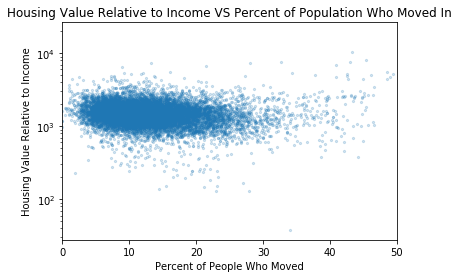

In [ ]:
fig, ax = plt.subplots()
plt.scatter(migration_all["total_diff_house"], migration_all["housing_value_relative_to_income"], s=5, alpha=0.2, label='Percent of Households Who Moved Houses')
plt.title("Housing Value Relative to Income VS Percent of Population Who Moved In")
plt.yscale("log")
plt.xlim([0,50])
plt.xlabel("Percent of People Who Moved")
plt.ylabel("Housing Value Relative to Income")

This shows a slight negative correlation between percent of people who moved in and housing value relative to income. One reason for this could be more people would want to move in to an area where housing values are lower percentage of their income since they would have to be able to afford to buy the home.  

Text(0, 0.5, 'Housing Value Relative to Income')

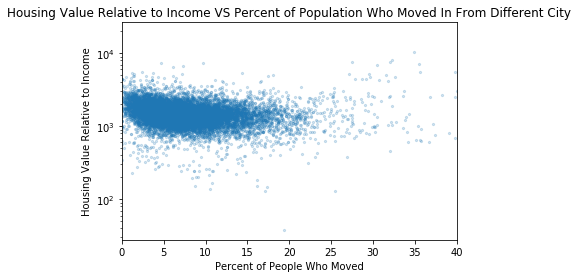

In [ ]:
fig, ax = plt.subplots()
plt.scatter(migration_all["diff_city"], migration_all["housing_value_relative_to_income"], s=5, alpha=0.2, label='Percent of Households Who Moved Houses')
plt.title("Housing Value Relative to Income VS Percent of Population Who Moved In From Different City")
plt.yscale("log")
plt.xlim([0,40])
plt.xlabel("Percent of People Who Moved")
plt.ylabel("Housing Value Relative to Income")

There is also a negative correlation between people who moved in from a different city specifically and housing value relative to income. A potential reason might be that for someone to move in from a different city, the housing value would need to be affordable thus being a lower percentage of their income. 

Text(0, 0.5, 'Housing Value Relative to Income')

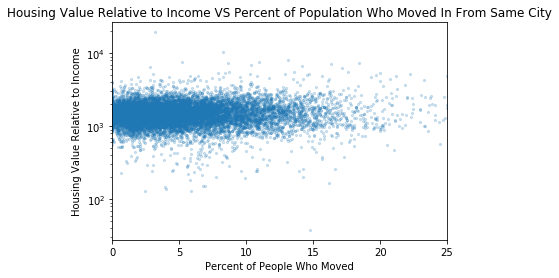

In [ ]:
fig, ax = plt.subplots()
plt.scatter(migration_all["same_city"], migration_all["housing_value_relative_to_income"], s=5, alpha=0.2, label='Percent of Households Who Moved Houses')
plt.title("Housing Value Relative to Income VS Percent of Population Who Moved In From Same City")
plt.yscale("log")
plt.xlim([0,25])
plt.xlabel("Percent of People Who Moved")
plt.ylabel("Housing Value Relative to Income")

No seeming correlation.

In [ ]:
%%bigquery --project $project_id sf_migration

SELECT
  year,
  ROUND((median_rent / income_per_capita)*100,2) AS rent_relative_to_income,
  ROUND((owner_occupied_housing_units_median_value / income_per_capita)*100,2) AS housing_value_relative_to_income,
  ROUND((different_house_year_ago_different_city / total_pop)*100,2) AS diff_city,
  ROUND((different_house_year_ago_same_city / total_pop)*100,2) AS same_city,
  ROUND(((different_house_year_ago_different_city + different_house_year_ago_same_city) / total_pop)*100,2) AS total_diff_house
FROM
  `cs145-proj3-final.cs145_proj3.censustract_concat_bay`
WHERE
  geo_id LIKE '06075%'
  AND median_rent IS NOT NULL
  AND owner_occupied_housing_units_median_value IS NOT NULL
ORDER BY
  year

The following graphs are a deeper dive into SF because SF seemed to exhibit different behaviors than the other counteis as seen by the graphs comparing migrations in  all the counties. Each correlation graph indicates a negative correlation between rent relative to income and percent of people who moved in. This is likely because the more people who are moving into an area the more likely that it's affordable to a wide range of people thus have rents that make up a lower percentage of one's income. 

Text(0, 0.5, 'Percent of Households Who Moved Houses')

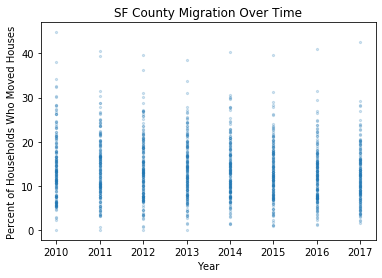

In [ ]:
fig, ax = plt.subplots()
plt.scatter(sf_migration["year"], sf_migration["total_diff_house"], s=5, alpha=0.2, label='Percent of Households Who Moved Houses')
plt.title("SF County Migration Over Time")
plt.xlabel("Year")
plt.ylabel("Percent of Households Who Moved Houses")

Text(0, 0.5, 'Rent Relative to Income')

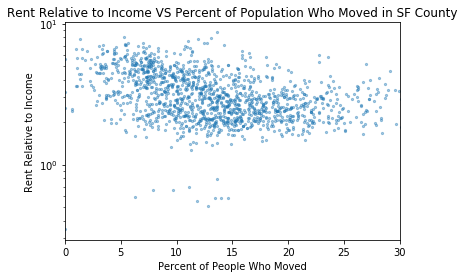

In [ ]:
fig, ax = plt.subplots()
plt.scatter(sf_migration["total_diff_house"], sf_migration["rent_relative_to_income"], s=5, alpha=0.4, label='Percent of Households Who Moved Houses')
plt.title("Rent Relative to Income VS Percent of Population Who Moved in SF County")
plt.yscale("log")
plt.xlim([0,30])
plt.xlabel("Percent of People Who Moved")
plt.ylabel("Rent Relative to Income")

Text(0, 0.5, 'Rent Relative to Income')

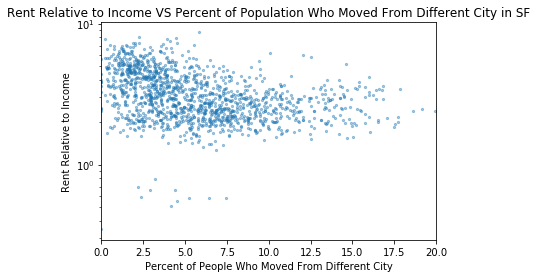

In [ ]:
fig, ax = plt.subplots()
plt.scatter(sf_migration["diff_city"], sf_migration["rent_relative_to_income"], s=5, alpha=0.4, label='Percent of Households Who Moved Houses')
plt.title("Rent Relative to Income VS Percent of Population Who Moved From Different City in SF")
plt.yscale("log")
plt.xlim([0,20])
plt.xlabel("Percent of People Who Moved From Different City")
plt.ylabel("Rent Relative to Income")

Text(0, 0.5, 'Rent Relative to Income')

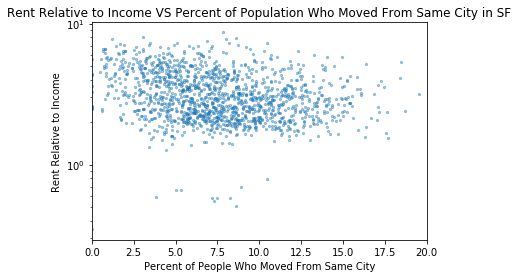

In [ ]:
fig, ax = plt.subplots()
plt.scatter(sf_migration["same_city"], sf_migration["rent_relative_to_income"], s=5, alpha=0.4, label='Percent of Households Who Moved Houses')
plt.title("Rent Relative to Income VS Percent of Population Who Moved From Same City in SF")
plt.yscale("log")
plt.xlim([0,20])
plt.xlabel("Percent of People Who Moved From Same City")
plt.ylabel("Rent Relative to Income")

**Inequity Score**

Inequity score of the Bay counties on income essentially measures how even the spread of people in each income bracket is across the 9 counties of the Bay Area. The following two graphs attempt to garner any relation between the socio-economic diversity across the counties and housing value/rentrelative to income.

In [ ]:
%%bigquery --project $project_id equity
SELECT year, ROUND(AVG(house_price_relative_to_income),2) AS house_relative_income, ROUND(AVG(rent_relative_to_income),2) AS rent_relative_income,
ROUND(SUM(income_less_10000+income_10000_14999+income_15000_19999+income_20000_24999+income_25000_29999+income_30000_34999 +income_35000_39999+ income_40000_44999 +income_45000_49999 +income_50000_59999 +income_60000_74999 +income_75000_99999+ income_100000_124999+ income_125000_149999+ income_150000_199999+ income_200000_or_more)/2,2) AS inequity_score
FROM (SELECT values.year, values.county, values.house_price_relative_to_income, values.rent_relative_to_income,
ABS(ROUND(((values.income_less_10000/sum.income_less_10000)-(values.total/sum.total))*(sum.income_less_10000/sum.total)*100,2)) AS income_less_10000,
  ABS(ROUND(((values.income_10000_14999/sum.income_10000_14999)-(values.total/sum.total))*(sum.income_10000_14999/sum.total)*100,2)) AS income_10000_14999,
  ABS(ROUND(((values.income_15000_19999/sum.income_15000_19999)-(values.total/sum.total))*(sum.income_15000_19999/sum.total)*100,2)) AS income_15000_19999,
  ABS(ROUND(((values.income_20000_24999/sum.income_20000_24999)-(values.total/sum.total))*(sum.income_20000_24999/sum.total)*100,2)) AS income_20000_24999,
  ABS(ROUND(((values.income_25000_29999/sum.income_25000_29999)-(values.total/sum.total))*(sum.income_25000_29999/sum.total)*100,2)) AS income_25000_29999,
 ABS(ROUND(((values.income_30000_34999/sum.income_30000_34999)-(values.total/sum.total))*(sum.income_30000_34999/sum.total)*100,2)) AS income_30000_34999,
  ABS(ROUND(((values.income_35000_39999/sum.income_35000_39999)-(values.total/sum.total))*(sum.income_35000_39999/sum.total)*100,2)) AS income_35000_39999,
  ABS(ROUND(((values.income_40000_44999/sum.income_40000_44999)-(values.total/sum.total))*(sum.income_40000_44999/sum.total)*100,2)) AS income_40000_44999,
  ABS(ROUND(((values.income_45000_49999/sum.income_45000_49999)-(values.total/sum.total))*(sum.income_45000_49999/sum.total)*100,2)) AS income_45000_49999,
  ABS(ROUND(((values.income_50000_59999/sum.income_50000_59999)-(values.total/sum.total))*(sum.income_50000_59999/sum.total)*100,2)) AS income_50000_59999,
  ABS(ROUND(((values.income_60000_74999/sum.income_60000_74999)-(values.total/sum.total))*(sum.income_60000_74999/sum.total)*100,2)) AS income_60000_74999,
  ABS(ROUND(((values.income_75000_99999/sum.income_75000_99999)-(values.total/sum.total))*(sum.income_75000_99999/sum.total)*100,2)) AS income_75000_99999,
  ABS(ROUND(((values.income_100000_124999/sum.income_100000_124999)-(values.total/sum.total))*(sum.income_100000_124999/sum.total)*100,2)) AS income_100000_124999,
  ABS(ROUND(((values.income_125000_149999/sum.income_125000_149999)-(values.total/sum.total))*(sum.income_125000_149999/sum.total)*100,2)) AS income_125000_149999,
  ABS(ROUND(((values.income_150000_199999/sum.income_150000_199999)-(values.total/sum.total))*(sum.income_150000_199999/sum.total)*100,2)) AS income_150000_199999,
  ABS(ROUND(((values.income_200000_or_more/sum.income_200000_or_more)-(values.total/sum.total))*(sum.income_200000_or_more/sum.total)*100,2)) AS income_200000_or_more
FROM
(SELECT * FROM `cs145-proj3-final.cs145_proj3.income_county_year` )values,
(SELECT year, SUM(income_less_10000) AS income_less_10000,
  SUM(income_10000_14999) AS income_10000_14999,
  SUM(income_15000_19999) AS income_15000_19999,
  SUM(income_20000_24999) AS income_20000_24999,
  SUM(income_25000_29999) AS income_25000_29999,
  SUM(income_30000_34999) AS income_30000_34999,
  SUM(income_35000_39999) AS income_35000_39999,
  SUM(income_40000_44999) AS income_40000_44999,
  SUM(income_45000_49999) AS income_45000_49999,
  SUM(income_50000_59999) AS income_50000_59999,
  SUM(income_60000_74999) AS income_60000_74999,
  SUM(income_75000_99999) AS income_75000_99999,
  SUM(income_100000_124999) AS income_100000_124999,
  SUM(income_125000_149999) AS income_125000_149999,
  SUM(income_150000_199999) AS income_150000_199999,
  SUM(income_200000_or_more) AS income_200000_or_more,
  SUM(total) AS total
FROM
  `cs145-proj3-final.cs145_proj3.income_county_year`
GROUP BY year
) sum
WHERE sum.year = values.year)
GROUP BY year
ORDER BY year


Text(0, 0.5, 'Inequity Score')

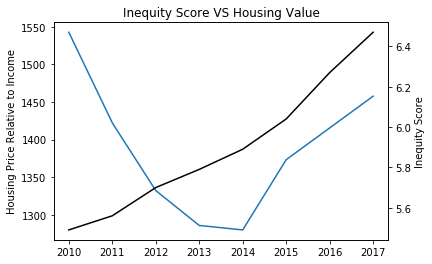

In [ ]:
fig, ax1 = plt.subplots()
ax1.plot(equity["year"],equity["house_relative_income"], label='Housing Value Relative to Income')
ax2 = ax1.twinx() 
ax2.plot(equity["year"], equity["inequity_score"], label="Inequity Score of Income Distribution Across Bay Counties",color="BLACK")
plt.title("Inequity Score VS Housing Value")
plt.xlabel("Year")
ax1.set_ylabel("Housing Price Relative to Income")
ax2.set_ylabel("Inequity Score")

Very likely no relation at all. However it is interesting to note that inequity score acorss the counties is getting higher. 

Text(0, 0.5, 'Inequity Score')

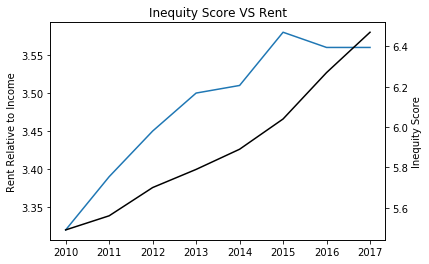

In [ ]:
fig, ax1 = plt.subplots()
ax1.plot(equity["year"],equity["rent_relative_income"], label='Rent Relative to Income')
ax2 = ax1.twinx() 
ax2.plot(equity["year"], equity["inequity_score"], label="Inequity Score of Income Distribution Across Bay Counties",color="BLACK")
plt.title("Inequity Score VS Rent")
plt.xlabel("Year")
ax1.set_ylabel("Rent Relative to Income")
ax2.set_ylabel("Inequity Score")

Temporally, it seems that there is a positive relationship between rent relative to income and the inequity score. 

**Income Brackets**

The following two figures takes a closer look into how trends are different for areas with different densities of socio-economic class. We used a query to find reasonable ranges to sort the income brackets into 'low', 'mid' and 'high'. Then we classified each census tract into one of these categories by finding which category most of the poulation fell into.

In [ ]:
%%bigquery --project $project_id income_brackets

SELECT
  *
FROM (
  SELECT
    CASE
      WHEN low_income > mid_income AND low_income > high_income THEN 'low'
      WHEN mid_income > low_income
    AND mid_income > high_income THEN 'mid'
      WHEN high_income > low_income AND high_income > mid_income THEN 'high'
  END
    AS majority,
    rent_relative_to_income,
    housing_value_relative_to_income
  FROM (
    SELECT
      ROUND((median_rent / income_per_capita)*100,2) AS rent_relative_to_income,
      ROUND((owner_occupied_housing_units_median_value / income_per_capita)*100,2) AS housing_value_relative_to_income,
      (income_less_10000 + income_10000_14999 + income_15000_19999 + income_20000_24999 + income_25000_29999 + income_30000_34999 + income_35000_39999 + income_40000_44999) AS low_income,
      (income_45000_49999 + income_50000_59999 + income_60000_74999 + income_75000_99999+income_100000_124999) AS mid_income,
      (income_125000_149999 + income_150000_199999 + income_200000_or_more) AS high_income
    FROM
      `cs145-proj3-final.cs145_proj3.censustract_concat_bay`
    WHERE
      median_rent IS NOT NULL
      AND owner_occupied_housing_units_median_value IS NOT NULL))
WHERE
  majority IS NOT NULL
ORDER BY
  CASE majority
    WHEN 'low' THEN 1
    WHEN 'mid' THEN 2
    WHEN 'high' THEN 3
END

In [ ]:
%%bigquery --project $project_id income_brackets_avg
SELECT
  majority,
  ROUND(AVG(rent_relative_to_income),2) AS rent,
  ROUND(AVG(housing_value_relative_to_income),2) AS housing_value
FROM (
  SELECT
    CASE
      WHEN low_income > mid_income AND low_income > high_income THEN 'low'
      WHEN mid_income > low_income
    AND mid_income > high_income THEN 'mid'
      WHEN high_income > low_income AND high_income > mid_income THEN 'high'
  END
    AS majority,
    rent_relative_to_income,
    housing_value_relative_to_income
  FROM (
    SELECT
      ROUND((median_rent / income_per_capita)*100,2) AS rent_relative_to_income,
      ROUND((owner_occupied_housing_units_median_value / income_per_capita)*100,2) AS housing_value_relative_to_income,
      (income_less_10000 + income_10000_14999 + income_15000_19999 + income_20000_24999 + income_25000_29999 + income_30000_34999 + income_35000_39999 + income_40000_44999) AS low_income,
      (income_45000_49999 + income_50000_59999 + income_60000_74999 + income_75000_99999+income_100000_124999) AS mid_income,
      (income_125000_149999 + income_150000_199999 + income_200000_or_more) AS high_income
    FROM
      `cs145-proj3-final.cs145_proj3.censustract_concat_bay`
    WHERE
      median_rent IS NOT NULL
      AND owner_occupied_housing_units_median_value IS NOT NULL))
WHERE
  majority IS NOT NULL
GROUP BY
  majority
ORDER BY
  CASE majority
    WHEN 'low' THEN 1
    WHEN 'mid' THEN 2
    WHEN 'high' THEN 3
END

In [ ]:
income_brackets_avg

,majority,rent,housing_value
0,low,4.75,1792.85
1,mid,4.35,1509.12
2,high,3.11,1463.92


Text(0, 0.5, 'Housing Value Relative to Income')

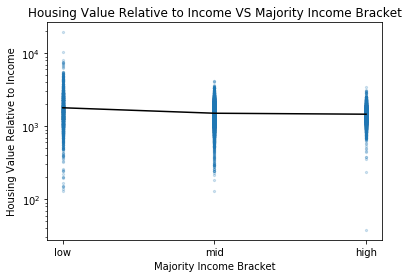

In [ ]:
fig, ax = plt.subplots()
plt.scatter(income_brackets["majority"], income_brackets["housing_value_relative_to_income"], s=5, alpha=0.2, label='Percent of Households Who Moved Houses')
ax.set_yscale("log")
plt.plot(income_brackets_avg["majority"], income_brackets_avg["housing_value"], color ="black")
plt.title("Housing Value Relative to Income VS Majority Income Bracket")
plt.xlabel("Majority Income Bracket")
plt.ylabel("Housing Value Relative to Income")

This shows that the higher the income bracket of the majority in a census tract, the smaller the range of housing value relative to income. This would suggest areas with majority residents from higher income backgrounds are likely less diverse in situation and housing market is relatively more similar across the area. Another explanation could be that housholds with higher income would have more control over the housing value since their income would allow them to have their pick of housing options. Additionally, the average housing value relative to income  decreases as there are more people in higher income brackets which supports the "house rich, cash poor" statement. 

Text(0, 0.5, 'Rent Relative to Income')

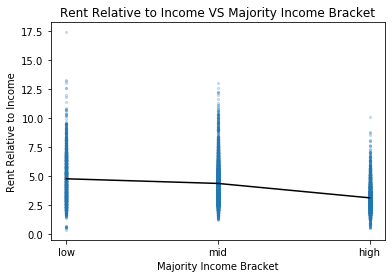

In [ ]:
fig, ax = plt.subplots()
plt.scatter(income_brackets["majority"], income_brackets["rent_relative_to_income"], s=5, alpha=0.2, label='Percent of Households Who Moved Houses')
# ax.set_yscale("log")
plt.plot(income_brackets_avg["majority"], income_brackets_avg["rent"], color ="black")
plt.title("Rent Relative to Income VS Majority Income Bracket")
plt.xlabel("Majority Income Bracket")
plt.ylabel("Rent Relative to Income")

Rents relative to income show also show a decrease in areas with higher income households. Renting is unaffordable for areas with a lot of low income residents as the average rent relative to income is 4.75% meaning on average annual rent is 57% of someone's annual income. The renting market is friendlier to those who can afford to live in areas with higher population of high income residents.

**Race**

In [ ]:
%%bigquery --project $project_id race

SELECT   ROUND((median_rent / income_per_capita)*100,2) AS rent_relative_to_income,
  ROUND((owner_occupied_housing_units_median_value / income_per_capita)*100,2) AS housing_value_relative_to_income,
ROUND((white_pop / (white_pop + black_pop + asian_pop + hispanic_pop + amerindian_pop + other_race_pop))*100, 2) AS white,
ROUND((black_pop / (white_pop + black_pop + asian_pop + hispanic_pop + amerindian_pop + other_race_pop))*100, 2) AS black,
ROUND((asian_pop / (white_pop + black_pop + asian_pop + hispanic_pop + amerindian_pop + other_race_pop))*100, 2) AS asian,
ROUND((hispanic_pop / (white_pop + black_pop + asian_pop + hispanic_pop + amerindian_pop + other_race_pop))*100, 2) AS hispanic,
ROUND((amerindian_pop / (white_pop + black_pop + asian_pop + hispanic_pop + amerindian_pop + other_race_pop))*100, 2) AS amerindian
FROM `cs145-proj3-final.cs145_proj3.censustract_concat_bay`
WHERE (white_pop + black_pop + asian_pop + hispanic_pop + amerindian_pop + other_race_pop) > 0

Text(0, 0.5, 'Housing Value Relative to Income')

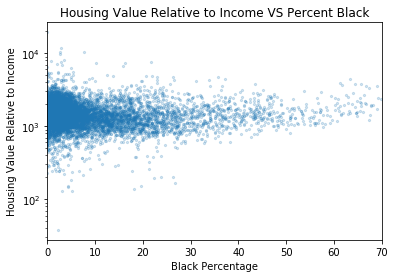

In [ ]:
fig, ax = plt.subplots()
plt.scatter(race["black"], race["housing_value_relative_to_income"], s=5, alpha=0.2, label='Percent of Households Who Moved Houses')
ax.set_yscale('log')
ax.set_xlim([0,70])
plt.title("Housing Value Relative to Income VS Percent Black")
plt.xlabel("Black Percentage")
plt.ylabel("Housing Value Relative to Income")

From this plot, there seems to be no correlation between percentage of black people in a census tract and housing value relatve to income. Since we predicted that communities with a high population of black minorities would have lower housing prices but also lower incomes, this lack of correlation was expected.

Text(0, 0.5, 'Housing Value Relative to Income')

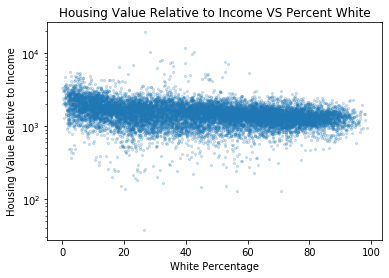

In [ ]:
fig, ax = plt.subplots()
plt.scatter(race["white"], race["housing_value_relative_to_income"], s=5, alpha=0.2, label='Percent of Households Who Moved Houses')
ax.set_yscale('log')
plt.title("Housing Value Relative to Income VS Percent White")
plt.xlabel("White Percentage")
plt.ylabel("Housing Value Relative to Income")

Slight negative correlation is observed. The larger the percentage of white people in an area, the lower the housing value relative to income is. This might be the case because in terms of salary, there is research that shows white employees often make more than their POC counterparts thus the higher the percentage of white people, the higher the incomes might be, causing a lower housing value relative to income. 

Text(0, 0.5, 'Housing Value Relative to Income')

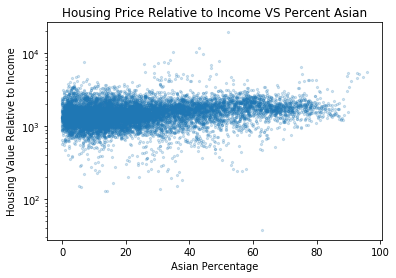

In [ ]:
fig, ax = plt.subplots()
plt.scatter(race["asian"], race["housing_value_relative_to_income"], s=5, alpha=0.2, label='Percent of Households Who Moved Houses')
ax.set_yscale('log')
plt.title("Housing Price Relative to Income VS Percent Asian")
plt.xlabel("Asian Percentage")
plt.ylabel("Housing Value Relative to Income")

There might be a slight positive correlation. The higher the percentage of Asians, the higher the housing value relative to income. 

Text(0, 0.5, 'Housing Value Relative to Income')

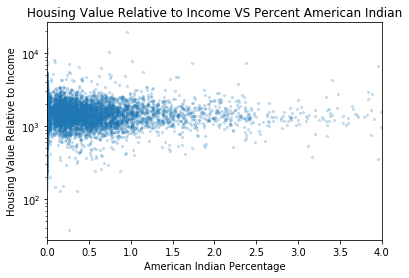

In [ ]:
fig, ax = plt.subplots()
plt.scatter(race["amerindian"], race["housing_value_relative_to_income"], s=5, alpha=0.2, label='Percent of Households Who Moved Houses')
ax.set_yscale('log')
ax.set_xlim([0,4])
plt.title("Housing Value Relative to Income VS Percent American Indian")
plt.xlabel("American Indian Percentage")
plt.ylabel("Housing Value Relative to Income")

There does not seem to be any correlation. It also seems that most census tracts in the Bay Area do not have a large population of American Indian people.

Text(0, 0.5, 'Rent Relative to Income')

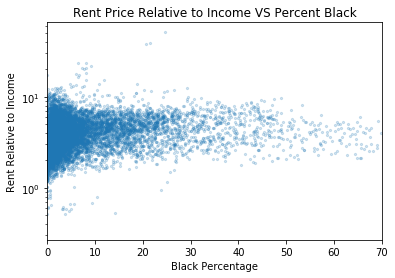

In [ ]:
fig, ax = plt.subplots()
plt.scatter(race["black"], race["rent_relative_to_income"], s=5, alpha=0.2)
plt.title("Rent Price Relative to Income VS Percent Black")
ax.set_yscale('log')
ax.set_xlim([0,70])
plt.xlabel("Black Percentage")
plt.ylabel("Rent Relative to Income")

There is no seeming correlation. However there is a strong tapering of the range of rents relative to income as areas have higher percentage of black residents. A potential reason is the more ethnically homogenous an area is the more likely that it's also a smaller range of  socio-economic diversity. 

Text(0, 0.5, 'Rent Relative to Income')

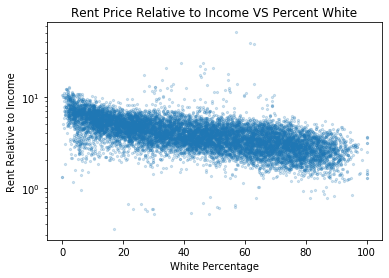

In [ ]:
fig, ax = plt.subplots()
plt.scatter(race["white"], race["rent_relative_to_income"], s=5, alpha=0.2)
plt.title("Rent Price Relative to Income VS Percent White")
ax.set_yscale('log')
plt.xlabel("White Percentage")
plt.ylabel("Rent Relative to Income")

There is a clear negative correlation between percentage of white people and rent relative to income. Similar to housing value, white residents might have a higher salary that their POC counterparts and therefore are able to spend a lower proportion of their income on rent.

Text(0, 0.5, 'Rent Relative to Income')

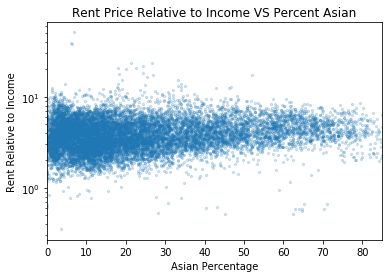

In [ ]:
fig, ax = plt.subplots()
plt.scatter(race["asian"], race["rent_relative_to_income"], s=5, alpha=0.2)
plt.title("Rent Price Relative to Income VS Percent Asian")
ax.set_yscale('log')
ax.set_xlim([0,85])
plt.xlabel("Asian Percentage")
plt.ylabel("Rent Relative to Income")

There does not seem to se an obvious correlation between Asian perentage and rent relative to income. 

Text(0, 0.5, 'Rent Relative to Income')

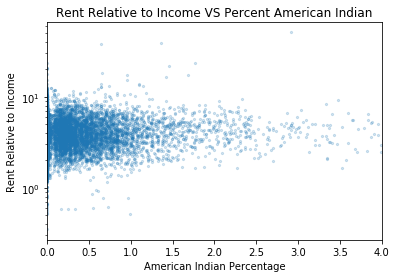

In [ ]:
fig, ax = plt.subplots()
plt.scatter(race["amerindian"], race["rent_relative_to_income"], s=5, alpha=0.2)
plt.title("Rent Relative to Income VS Percent American Indian")
ax.set_yscale('log')
ax.set_xlim([0,4])
plt.xlabel("American Indian Percentage")
plt.ylabel("Rent Relative to Income")

No correlation is observed between American Indian percentage and rent relative to income. The fact that few census tracts had an American Indian percentage above 2% indicates that their aggregate impact on rent relative to income.

**Employment**

The following  two graphs were made to give us a better understanding of what employment groups would likely yield a correlation with rent and housing value relative to income.

In [ ]:
%%bigquery --project $project_id employment

SELECT 
CASE
    WHEN geo_id LIKE '06001%'   THEN 'Alameda'
    WHEN geo_id LIKE '06013%' THEN 'Contra Costa'
    WHEN geo_id LIKE '06041%' THEN 'Marin'
    WHEN geo_id LIKE '06055%' THEN 'Napa'
    WHEN geo_id LIKE '06075%' THEN 'San Francisco'
    WHEN geo_id LIKE '06081%' THEN 'San Mateo'
    WHEN geo_id LIKE '06085%' THEN 'Santa Clara'
    WHEN geo_id LIKE '06095%' THEN 'Solano'
    WHEN geo_id LIKE '06097%' THEN 'Sonoma'
  END AS county,
AVG(ROUND((owner_occupied_housing_units_median_value / income_per_capita)*100,2)) AS housing_value_relative_to_income,
AVG(ROUND((median_rent / income_per_capita)*100,2)) AS rent_relative_to_income,
AVG(ROUND(employed_agriculture_forestry_fishing_hunting_mining / (employed_agriculture_forestry_fishing_hunting_mining + employed_arts_entertainment_recreation_accommodation_food + employed_construction + employed_education_health_social + employed_finance_insurance_real_estate + employed_information + employed_manufacturing + employed_other_services_not_public_admin + employed_public_administration + employed_retail_trade + employed_science_management_admin_waste + employed_transportation_warehousing_utilities + employed_wholesale_trade)*100, 2)) AS agriculture_forestry_fishing_hunting_mining,
AVG(ROUND(employed_arts_entertainment_recreation_accommodation_food / (employed_agriculture_forestry_fishing_hunting_mining + employed_arts_entertainment_recreation_accommodation_food + employed_construction + employed_education_health_social + employed_finance_insurance_real_estate + employed_information + employed_manufacturing + employed_other_services_not_public_admin + employed_public_administration + employed_retail_trade + employed_science_management_admin_waste + employed_transportation_warehousing_utilities + employed_wholesale_trade)*100, 2)) AS arts_entertainment_recreation_accommodation_food,
AVG(ROUND(employed_construction / (employed_agriculture_forestry_fishing_hunting_mining + employed_arts_entertainment_recreation_accommodation_food + employed_construction + employed_education_health_social + employed_finance_insurance_real_estate + employed_information + employed_manufacturing + employed_other_services_not_public_admin + employed_public_administration + employed_retail_trade + employed_science_management_admin_waste + employed_transportation_warehousing_utilities + employed_wholesale_trade)*100, 2)) AS construction,
AVG(ROUND(employed_education_health_social / (employed_agriculture_forestry_fishing_hunting_mining + employed_arts_entertainment_recreation_accommodation_food + employed_construction + employed_education_health_social + employed_finance_insurance_real_estate + employed_information + employed_manufacturing + employed_other_services_not_public_admin + employed_public_administration + employed_retail_trade + employed_science_management_admin_waste + employed_transportation_warehousing_utilities + employed_wholesale_trade)*100, 2)) AS education_health_social,
AVG(ROUND(employed_finance_insurance_real_estate / (employed_agriculture_forestry_fishing_hunting_mining + employed_arts_entertainment_recreation_accommodation_food + employed_construction + employed_education_health_social + employed_finance_insurance_real_estate + employed_information + employed_manufacturing + employed_other_services_not_public_admin + employed_public_administration + employed_retail_trade + employed_science_management_admin_waste + employed_transportation_warehousing_utilities + employed_wholesale_trade)*100, 2)) AS finance_insurance_real_estate,
AVG(ROUND(employed_information / (employed_agriculture_forestry_fishing_hunting_mining + employed_arts_entertainment_recreation_accommodation_food + employed_construction + employed_education_health_social + employed_finance_insurance_real_estate + employed_information + employed_manufacturing + employed_other_services_not_public_admin + employed_public_administration + employed_retail_trade + employed_science_management_admin_waste + employed_transportation_warehousing_utilities + employed_wholesale_trade)*100, 2)) AS information,
AVG(ROUND(employed_manufacturing / (employed_agriculture_forestry_fishing_hunting_mining + employed_arts_entertainment_recreation_accommodation_food + employed_construction + employed_education_health_social + employed_finance_insurance_real_estate + employed_information + employed_manufacturing + employed_other_services_not_public_admin + employed_public_administration + employed_retail_trade + employed_science_management_admin_waste + employed_transportation_warehousing_utilities + employed_wholesale_trade)*100, 2)) AS manufacturing,
AVG(ROUND(employed_other_services_not_public_admin / (employed_agriculture_forestry_fishing_hunting_mining + employed_arts_entertainment_recreation_accommodation_food + employed_construction + employed_education_health_social + employed_finance_insurance_real_estate + employed_information + employed_manufacturing + employed_other_services_not_public_admin + employed_public_administration + employed_retail_trade + employed_science_management_admin_waste + employed_transportation_warehousing_utilities + employed_wholesale_trade)*100, 2)) AS other_services_not_public_admin,
AVG(ROUND(employed_public_administration / (employed_agriculture_forestry_fishing_hunting_mining + employed_arts_entertainment_recreation_accommodation_food + employed_construction + employed_education_health_social + employed_finance_insurance_real_estate + employed_information + employed_manufacturing + employed_other_services_not_public_admin + employed_public_administration + employed_retail_trade + employed_science_management_admin_waste + employed_transportation_warehousing_utilities + employed_wholesale_trade)*100, 2)) AS public_administration,
AVG(ROUND(employed_retail_trade / (employed_agriculture_forestry_fishing_hunting_mining + employed_arts_entertainment_recreation_accommodation_food + employed_construction + employed_education_health_social + employed_finance_insurance_real_estate + employed_information + employed_manufacturing + employed_other_services_not_public_admin + employed_public_administration + employed_retail_trade + employed_science_management_admin_waste + employed_transportation_warehousing_utilities + employed_wholesale_trade)*100, 2)) AS retail_trade,
AVG(ROUND(employed_science_management_admin_waste / (employed_agriculture_forestry_fishing_hunting_mining + employed_arts_entertainment_recreation_accommodation_food + employed_construction + employed_education_health_social + employed_finance_insurance_real_estate + employed_information + employed_manufacturing + employed_other_services_not_public_admin + employed_public_administration + employed_retail_trade + employed_science_management_admin_waste + employed_transportation_warehousing_utilities + employed_wholesale_trade)*100, 2)) AS science_management_admin_waste,
AVG(ROUND(employed_transportation_warehousing_utilities / (employed_agriculture_forestry_fishing_hunting_mining + employed_arts_entertainment_recreation_accommodation_food + employed_construction + employed_education_health_social + employed_finance_insurance_real_estate + employed_information + employed_manufacturing + employed_other_services_not_public_admin + employed_public_administration + employed_retail_trade + employed_science_management_admin_waste + employed_transportation_warehousing_utilities + employed_wholesale_trade)*100, 2)) AS transportation_warehousing_utilities,
AVG(ROUND(employed_wholesale_trade / (employed_agriculture_forestry_fishing_hunting_mining + employed_arts_entertainment_recreation_accommodation_food + employed_construction + employed_education_health_social + employed_finance_insurance_real_estate + employed_information + employed_manufacturing + employed_other_services_not_public_admin + employed_public_administration + employed_retail_trade + employed_science_management_admin_waste + employed_transportation_warehousing_utilities + employed_wholesale_trade)*100, 2)) AS wholesale_trade
FROM `cs145-proj3-final.cs145_proj3.censustract_concat_bay`
WHERE (employed_agriculture_forestry_fishing_hunting_mining + employed_arts_entertainment_recreation_accommodation_food + employed_construction + employed_education_health_social + employed_finance_insurance_real_estate + employed_information + employed_manufacturing + employed_other_services_not_public_admin + employed_public_administration + employed_retail_trade + employed_science_management_admin_waste + employed_transportation_warehousing_utilities + employed_wholesale_trade) > 0
GROUP BY 
  CASE
    WHEN geo_id LIKE '06001%'   THEN 'Alameda'
    WHEN geo_id LIKE '06013%' THEN 'Contra Costa'
    WHEN geo_id LIKE '06041%' THEN 'Marin'
    WHEN geo_id LIKE '06055%' THEN 'Napa'
    WHEN geo_id LIKE '06075%' THEN 'San Francisco'
    WHEN geo_id LIKE '06081%' THEN 'San Mateo'
    WHEN geo_id LIKE '06085%' THEN 'Santa Clara'
    WHEN geo_id LIKE '06095%' THEN 'Solano'
    WHEN geo_id LIKE '06097%' THEN 'Sonoma'
  END

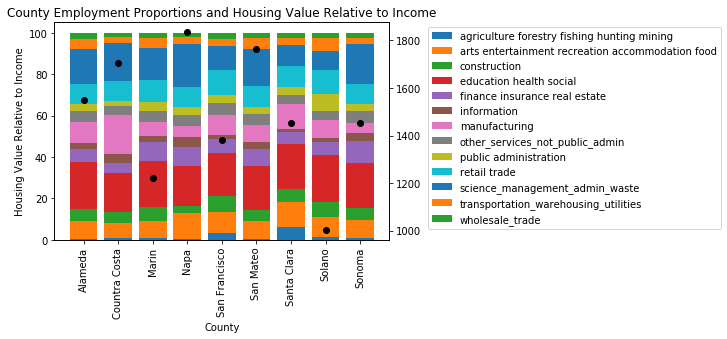

In [ ]:
fig, ax1 = plt.subplots()
ind = [0,1,2,3,4,5,6,7,8]
names = ['Alameda','Countra Costa','Marin','Napa','San Francisco', 'San Mateo', 'Santa Clara', 'Solano', 'Sonoma']
p1 = plt.bar(ind, employment["agriculture_forestry_fishing_hunting_mining"])
p2 = plt.bar(ind, employment["arts_entertainment_recreation_accommodation_food"], bottom=employment["agriculture_forestry_fishing_hunting_mining"])
p3 = plt.bar(ind, employment["construction"], bottom=employment["arts_entertainment_recreation_accommodation_food"]+employment["agriculture_forestry_fishing_hunting_mining"])
p4 = plt.bar(ind, employment["education_health_social"], bottom=employment["construction"]+employment["arts_entertainment_recreation_accommodation_food"]+employment["agriculture_forestry_fishing_hunting_mining"])
p5 = plt.bar(ind, employment["finance_insurance_real_estate"], bottom=employment["education_health_social"]+employment["construction"]+employment["arts_entertainment_recreation_accommodation_food"]+employment["agriculture_forestry_fishing_hunting_mining"])
p6 = plt.bar(ind, employment["information"], bottom=employment["finance_insurance_real_estate"]+employment["education_health_social"]+employment["construction"]+employment["arts_entertainment_recreation_accommodation_food"]+employment["agriculture_forestry_fishing_hunting_mining"])
p7 = plt.bar(ind, employment["manufacturing"], bottom=employment["information"]+employment["finance_insurance_real_estate"]+employment["education_health_social"]+employment["construction"]+employment["arts_entertainment_recreation_accommodation_food"]+employment["agriculture_forestry_fishing_hunting_mining"])
p8 = plt.bar(ind, employment["other_services_not_public_admin"], bottom=employment["manufacturing"]+employment["information"]+employment["finance_insurance_real_estate"]+employment["education_health_social"]+employment["construction"]+employment["arts_entertainment_recreation_accommodation_food"]+employment["agriculture_forestry_fishing_hunting_mining"])
p9 = plt.bar(ind, employment["public_administration"], bottom=employment["other_services_not_public_admin"]+employment["manufacturing"]+employment["information"]+employment["finance_insurance_real_estate"]+employment["education_health_social"]+employment["construction"]+employment["arts_entertainment_recreation_accommodation_food"]+employment["agriculture_forestry_fishing_hunting_mining"])
p10 = plt.bar(ind, employment["retail_trade"], bottom=employment["public_administration"]+employment["other_services_not_public_admin"]+employment["manufacturing"]+employment["information"]+employment["finance_insurance_real_estate"]+employment["education_health_social"]+employment["construction"]+employment["arts_entertainment_recreation_accommodation_food"]+employment["agriculture_forestry_fishing_hunting_mining"])
p11 = plt.bar(ind, employment["science_management_admin_waste"], bottom=employment["retail_trade"]+employment["public_administration"]+employment["other_services_not_public_admin"]+employment["manufacturing"]+employment["information"]+employment["finance_insurance_real_estate"]+employment["education_health_social"]+employment["construction"]+employment["arts_entertainment_recreation_accommodation_food"]+employment["agriculture_forestry_fishing_hunting_mining"])
p12 = plt.bar(ind, employment["transportation_warehousing_utilities"], bottom=employment["science_management_admin_waste"]+employment["retail_trade"]+employment["public_administration"]+employment["other_services_not_public_admin"]+employment["manufacturing"]+employment["information"]+employment["finance_insurance_real_estate"]+employment["education_health_social"]+employment["construction"]+employment["arts_entertainment_recreation_accommodation_food"]+employment["agriculture_forestry_fishing_hunting_mining"])
p13 = plt.bar(ind, employment["wholesale_trade"], bottom=employment["transportation_warehousing_utilities"]+employment["science_management_admin_waste"]+employment["retail_trade"]+employment["public_administration"]+employment["other_services_not_public_admin"]+employment["manufacturing"]+employment["information"]+employment["finance_insurance_real_estate"]+employment["education_health_social"]+employment["construction"]+employment["arts_entertainment_recreation_accommodation_food"]+employment["agriculture_forestry_fishing_hunting_mining"])
plt.xticks(ind, names, rotation=90)
plt.legend((p1[0], p2[0], p3[0], p4[0], p5[0], p6[0], p7[0], p8[0], p9[0], p10[0], p11[0], p12[0], p13[0]), ('agriculture forestry fishing hunting mining', 'arts entertainment recreation accommodation food', 'construction', 'education health social', 'finance insurance real estate', 'information', 'manufacturing', 'other_services_not_public_admin', 'public administration', 'retail trade', 'science_management_admin_waste', 'transportation_warehousing_utilities', 'wholesale_trade'),bbox_to_anchor=(1.1, 1))
plt.title("County Employment Proportions and Housing Value Relative to Income")
plt.xlabel("County")
ax1.set_ylabel("Occupation Percentage")
ax2 = ax1.twinx() 
ax1.set_ylabel("Housing Value Relative to Income")
ax2.scatter(ind, employment['housing_value_relative_to_income'], color='black')
plt.show()

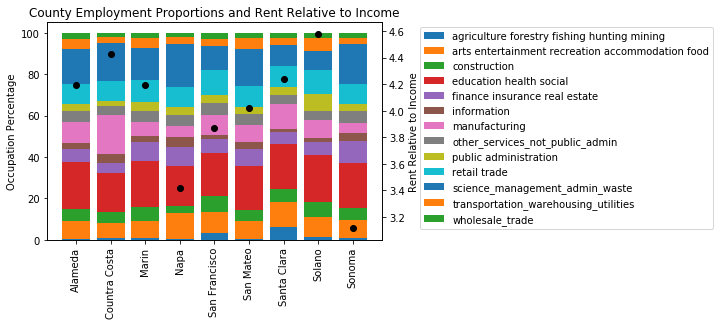

In [ ]:
fig, ax1 = plt.subplots()
ind = [0,1,2,3,4,5,6,7,8]
names = ['Alameda','Countra Costa','Marin','Napa','San Francisco', 'San Mateo', 'Santa Clara', 'Solano', 'Sonoma']
p1 = plt.bar(ind, employment["agriculture_forestry_fishing_hunting_mining"])
p2 = plt.bar(ind, employment["arts_entertainment_recreation_accommodation_food"], bottom=employment["agriculture_forestry_fishing_hunting_mining"])
p3 = plt.bar(ind, employment["construction"], bottom=employment["arts_entertainment_recreation_accommodation_food"]+employment["agriculture_forestry_fishing_hunting_mining"])
p4 = plt.bar(ind, employment["education_health_social"], bottom=employment["construction"]+employment["arts_entertainment_recreation_accommodation_food"]+employment["agriculture_forestry_fishing_hunting_mining"])
p5 = plt.bar(ind, employment["finance_insurance_real_estate"], bottom=employment["education_health_social"]+employment["construction"]+employment["arts_entertainment_recreation_accommodation_food"]+employment["agriculture_forestry_fishing_hunting_mining"])
p6 = plt.bar(ind, employment["information"], bottom=employment["finance_insurance_real_estate"]+employment["education_health_social"]+employment["construction"]+employment["arts_entertainment_recreation_accommodation_food"]+employment["agriculture_forestry_fishing_hunting_mining"])
p7 = plt.bar(ind, employment["manufacturing"], bottom=employment["information"]+employment["finance_insurance_real_estate"]+employment["education_health_social"]+employment["construction"]+employment["arts_entertainment_recreation_accommodation_food"]+employment["agriculture_forestry_fishing_hunting_mining"])
p8 = plt.bar(ind, employment["other_services_not_public_admin"], bottom=employment["manufacturing"]+employment["information"]+employment["finance_insurance_real_estate"]+employment["education_health_social"]+employment["construction"]+employment["arts_entertainment_recreation_accommodation_food"]+employment["agriculture_forestry_fishing_hunting_mining"])
p9 = plt.bar(ind, employment["public_administration"], bottom=employment["other_services_not_public_admin"]+employment["manufacturing"]+employment["information"]+employment["finance_insurance_real_estate"]+employment["education_health_social"]+employment["construction"]+employment["arts_entertainment_recreation_accommodation_food"]+employment["agriculture_forestry_fishing_hunting_mining"])
p10 = plt.bar(ind, employment["retail_trade"], bottom=employment["public_administration"]+employment["other_services_not_public_admin"]+employment["manufacturing"]+employment["information"]+employment["finance_insurance_real_estate"]+employment["education_health_social"]+employment["construction"]+employment["arts_entertainment_recreation_accommodation_food"]+employment["agriculture_forestry_fishing_hunting_mining"])
p11 = plt.bar(ind, employment["science_management_admin_waste"], bottom=employment["retail_trade"]+employment["public_administration"]+employment["other_services_not_public_admin"]+employment["manufacturing"]+employment["information"]+employment["finance_insurance_real_estate"]+employment["education_health_social"]+employment["construction"]+employment["arts_entertainment_recreation_accommodation_food"]+employment["agriculture_forestry_fishing_hunting_mining"])
p12 = plt.bar(ind, employment["transportation_warehousing_utilities"], bottom=employment["science_management_admin_waste"]+employment["retail_trade"]+employment["public_administration"]+employment["other_services_not_public_admin"]+employment["manufacturing"]+employment["information"]+employment["finance_insurance_real_estate"]+employment["education_health_social"]+employment["construction"]+employment["arts_entertainment_recreation_accommodation_food"]+employment["agriculture_forestry_fishing_hunting_mining"])
p13 = plt.bar(ind, employment["wholesale_trade"], bottom=employment["transportation_warehousing_utilities"]+employment["science_management_admin_waste"]+employment["retail_trade"]+employment["public_administration"]+employment["other_services_not_public_admin"]+employment["manufacturing"]+employment["information"]+employment["finance_insurance_real_estate"]+employment["education_health_social"]+employment["construction"]+employment["arts_entertainment_recreation_accommodation_food"]+employment["agriculture_forestry_fishing_hunting_mining"])
plt.xticks(ind, names, rotation=90)
plt.legend((p1[0], p2[0], p3[0], p4[0], p5[0], p6[0], p7[0], p8[0], p9[0], p10[0], p11[0], p12[0], p13[0]), ('agriculture forestry fishing hunting mining', 'arts entertainment recreation accommodation food', 'construction', 'education health social', 'finance insurance real estate', 'information', 'manufacturing', 'other_services_not_public_admin', 'public administration', 'retail trade', 'science_management_admin_waste', 'transportation_warehousing_utilities', 'wholesale_trade'),bbox_to_anchor=(1.1, 1))
plt.title("County Employment Proportions and Rent Relative to Income")
plt.ylabel("County")
ax1.set_ylabel("Occupation Percentage")
ax2 = ax1.twinx() 
ax2.set_ylabel("Rent Relative to Income")
ax2.scatter(ind, employment['rent_relative_to_income'], color='black')
plt.show()

Observing the above two graphs showed no distinct correlation between occupation percentage of any percentage type and housing value/rent relative to income. Therefore, we individually generated scatter plots for employment type against housing value/rent relative to come.

In [ ]:
%%bigquery --project $project_id employment_all

SELECT
ROUND((owner_occupied_housing_units_median_value / income_per_capita)*100,2) AS housing_value_relative_to_income,
ROUND((median_rent / income_per_capita)*100,2) AS rent_relative_to_income,
ROUND(employed_agriculture_forestry_fishing_hunting_mining / (employed_agriculture_forestry_fishing_hunting_mining + employed_arts_entertainment_recreation_accommodation_food + employed_construction + employed_education_health_social + employed_finance_insurance_real_estate + employed_information + employed_manufacturing + employed_other_services_not_public_admin + employed_public_administration + employed_retail_trade + employed_science_management_admin_waste + employed_transportation_warehousing_utilities + employed_wholesale_trade)*100, 2) AS agriculture_forestry_fishing_hunting_mining,
ROUND(employed_arts_entertainment_recreation_accommodation_food / (employed_agriculture_forestry_fishing_hunting_mining + employed_arts_entertainment_recreation_accommodation_food + employed_construction + employed_education_health_social + employed_finance_insurance_real_estate + employed_information + employed_manufacturing + employed_other_services_not_public_admin + employed_public_administration + employed_retail_trade + employed_science_management_admin_waste + employed_transportation_warehousing_utilities + employed_wholesale_trade)*100, 2) AS arts_entertainment_recreation_accommodation_food,
ROUND(employed_construction / (employed_agriculture_forestry_fishing_hunting_mining + employed_arts_entertainment_recreation_accommodation_food + employed_construction + employed_education_health_social + employed_finance_insurance_real_estate + employed_information + employed_manufacturing + employed_other_services_not_public_admin + employed_public_administration + employed_retail_trade + employed_science_management_admin_waste + employed_transportation_warehousing_utilities + employed_wholesale_trade)*100, 2) AS construction,
ROUND(employed_education_health_social / (employed_agriculture_forestry_fishing_hunting_mining + employed_arts_entertainment_recreation_accommodation_food + employed_construction + employed_education_health_social + employed_finance_insurance_real_estate + employed_information + employed_manufacturing + employed_other_services_not_public_admin + employed_public_administration + employed_retail_trade + employed_science_management_admin_waste + employed_transportation_warehousing_utilities + employed_wholesale_trade)*100, 2) AS education_health_social,
ROUND(employed_finance_insurance_real_estate / (employed_agriculture_forestry_fishing_hunting_mining + employed_arts_entertainment_recreation_accommodation_food + employed_construction + employed_education_health_social + employed_finance_insurance_real_estate + employed_information + employed_manufacturing + employed_other_services_not_public_admin + employed_public_administration + employed_retail_trade + employed_science_management_admin_waste + employed_transportation_warehousing_utilities + employed_wholesale_trade)*100, 2) AS finance_insurance_real_estate,
ROUND(employed_information / (employed_agriculture_forestry_fishing_hunting_mining + employed_arts_entertainment_recreation_accommodation_food + employed_construction + employed_education_health_social + employed_finance_insurance_real_estate + employed_information + employed_manufacturing + employed_other_services_not_public_admin + employed_public_administration + employed_retail_trade + employed_science_management_admin_waste + employed_transportation_warehousing_utilities + employed_wholesale_trade)*100, 2) AS information,
ROUND(employed_manufacturing / (employed_agriculture_forestry_fishing_hunting_mining + employed_arts_entertainment_recreation_accommodation_food + employed_construction + employed_education_health_social + employed_finance_insurance_real_estate + employed_information + employed_manufacturing + employed_other_services_not_public_admin + employed_public_administration + employed_retail_trade + employed_science_management_admin_waste + employed_transportation_warehousing_utilities + employed_wholesale_trade)*100, 2) AS manufacturing,
ROUND(employed_other_services_not_public_admin / (employed_agriculture_forestry_fishing_hunting_mining + employed_arts_entertainment_recreation_accommodation_food + employed_construction + employed_education_health_social + employed_finance_insurance_real_estate + employed_information + employed_manufacturing + employed_other_services_not_public_admin + employed_public_administration + employed_retail_trade + employed_science_management_admin_waste + employed_transportation_warehousing_utilities + employed_wholesale_trade)*100, 2) AS other_services_not_public_admin,
ROUND(employed_public_administration / (employed_agriculture_forestry_fishing_hunting_mining + employed_arts_entertainment_recreation_accommodation_food + employed_construction + employed_education_health_social + employed_finance_insurance_real_estate + employed_information + employed_manufacturing + employed_other_services_not_public_admin + employed_public_administration + employed_retail_trade + employed_science_management_admin_waste + employed_transportation_warehousing_utilities + employed_wholesale_trade)*100, 2) AS public_administration,
ROUND(employed_retail_trade / (employed_agriculture_forestry_fishing_hunting_mining + employed_arts_entertainment_recreation_accommodation_food + employed_construction + employed_education_health_social + employed_finance_insurance_real_estate + employed_information + employed_manufacturing + employed_other_services_not_public_admin + employed_public_administration + employed_retail_trade + employed_science_management_admin_waste + employed_transportation_warehousing_utilities + employed_wholesale_trade)*100, 2) AS retail_trade,
ROUND(employed_science_management_admin_waste / (employed_agriculture_forestry_fishing_hunting_mining + employed_arts_entertainment_recreation_accommodation_food + employed_construction + employed_education_health_social + employed_finance_insurance_real_estate + employed_information + employed_manufacturing + employed_other_services_not_public_admin + employed_public_administration + employed_retail_trade + employed_science_management_admin_waste + employed_transportation_warehousing_utilities + employed_wholesale_trade)*100, 2) AS science_management_admin_waste,
ROUND(employed_transportation_warehousing_utilities / (employed_agriculture_forestry_fishing_hunting_mining + employed_arts_entertainment_recreation_accommodation_food + employed_construction + employed_education_health_social + employed_finance_insurance_real_estate + employed_information + employed_manufacturing + employed_other_services_not_public_admin + employed_public_administration + employed_retail_trade + employed_science_management_admin_waste + employed_transportation_warehousing_utilities + employed_wholesale_trade)*100, 2) AS transportation_warehousing_utilities,
ROUND(employed_wholesale_trade / (employed_agriculture_forestry_fishing_hunting_mining + employed_arts_entertainment_recreation_accommodation_food + employed_construction + employed_education_health_social + employed_finance_insurance_real_estate + employed_information + employed_manufacturing + employed_other_services_not_public_admin + employed_public_administration + employed_retail_trade + employed_science_management_admin_waste + employed_transportation_warehousing_utilities + employed_wholesale_trade)*100, 2) AS wholesale_trade
FROM `cs145-proj3-final.cs145_proj3.censustract_concat_bay`
WHERE (employed_agriculture_forestry_fishing_hunting_mining + employed_arts_entertainment_recreation_accommodation_food + employed_construction + employed_education_health_social + employed_finance_insurance_real_estate + employed_information + employed_manufacturing + employed_other_services_not_public_admin + employed_public_administration + employed_retail_trade + employed_science_management_admin_waste + employed_transportation_warehousing_utilities + employed_wholesale_trade) > 0

(0, 15)

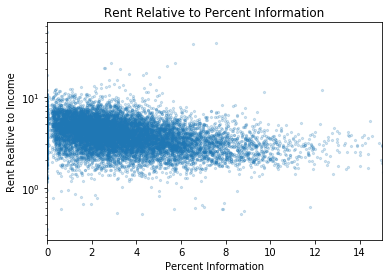

In [ ]:
fig, ax = plt.subplots()
plt.scatter(employment_all["information"], employment_all["rent_relative_to_income"], s=5, alpha=0.2)
plt.title("Rent Relative to Percent Information")
plt.xlabel("Percent Information")
plt.ylabel("Rent Realtive to Income")
ax.set_yscale('log')
ax.set_xlim([0,15])

A slight negative correlation was observed between percentage of people in the information sector and rent relative to income. Jobs under the information category are likely higher paying so rents are a lower percent of income. 

(0, 30)

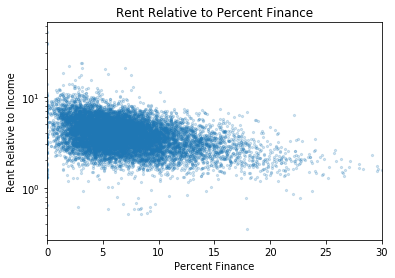

In [ ]:
fig, ax = plt.subplots()
plt.scatter(employment_all["finance_insurance_real_estate"], employment_all["rent_relative_to_income"], s=5, alpha=0.2, label='Percent of Households Who Moved Houses')
plt.title("Rent Relative to Percent Finance")
plt.xlabel("Percent Finance")
plt.ylabel("Rent Relative to Income")
ax.set_yscale('log')
ax.set_xlim([0,30])

A slight negative correlation was observed between percentage of people in finance and rent relative to income. Like jobs under the information category, jobs in finance are likely high paying so rents are a lower percent of income. 

(0, 20)

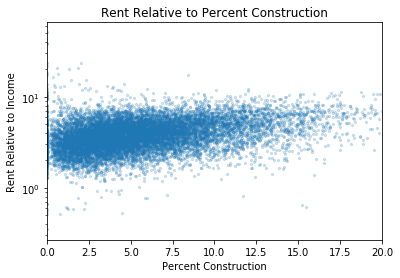

In [ ]:
fig, ax = plt.subplots()
plt.scatter(employment_all["construction"], employment_all["rent_relative_to_income"], s=5, alpha=0.2, label='Percent of Households Who Moved Houses')
plt.title("Rent Relative to Percent Construction")
plt.xlabel("Percent Construction")
plt.ylabel("Rent Relative to Income")
ax.set_yscale('log')
ax.set_xlim([0,20])

There is a distinct positive correlation between rent relative to income and percentage of workers in construction. Those who work in construction might not get as high of an income and the renting prices in the Bay have a high lower bound, resulting in this correlation.

**Commute Time**

In [ ]:
%%bigquery --project $project_id commute_time

SELECT 
ROUND((owner_occupied_housing_units_median_value / income_per_capita)*100, 2) AS housing_value_relative_to_income,
ROUND((median_rent / income_per_capita)*100, 2) AS rent_relative_to_income,
ROUND((commute_5_9_mins*5 + commute_10_14_mins*10 + commute_15_19_mins*15 + commute_20_24_mins*20 + commute_25_29_mins*25 + commute_30_34_mins*30 + commute_35_39_mins*35 + commute_40_44_mins*40 + commute_45_59_mins*45 + commute_60_89_mins*60 + commute_90_more_mins*90) / (commute_5_9_mins + commute_10_14_mins + commute_15_19_mins + commute_20_24_mins + commute_25_29_mins + commute_30_34_mins + commute_35_39_mins + commute_40_44_mins + commute_45_59_mins + commute_60_89_mins + commute_90_more_mins), 2) AS commute
FROM `cs145-proj3-final.cs145_proj3.censustract_concat_bay`
WHERE (commute_5_9_mins + commute_10_14_mins + commute_15_19_mins + commute_20_24_mins + commute_25_29_mins + commute_30_34_mins + commute_35_39_mins + commute_40_44_mins + commute_45_59_mins + commute_60_89_mins + commute_90_more_mins) > 0

(15, 45)

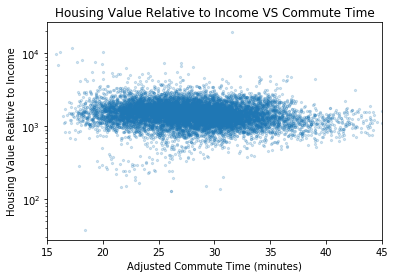

In [ ]:
fig, ax = plt.subplots()
plt.scatter(commute_time["commute"], commute_time["housing_value_relative_to_income"], s=5, alpha=0.2)
plt.title("Housing Value Relative to Income VS Commute Time")
plt.xlabel("Adjusted Commute Time (minutes)")
plt.ylabel("Housing Value Realtive to Income")
ax.set_yscale('log')
ax.set_xlim([15,45])

We expected to find a negative correlation between adjusted commute time and housing value relative to income. This is because housing value is likely to be higher closer to places of worker, though this depends on the type of employment. The tradeoff between commute time and housing value is a common dillema people face when finding homes. However, we cannot observe any correlation in this graph. This may be because the high baseline housing prices in the Bay Area negates the impact that commute time has on housing purchases.

Text(0, 0.5, 'Rent Realtive to Income')

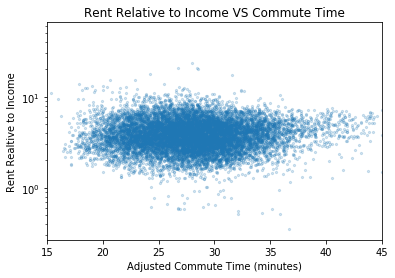

In [ ]:
fig, ax = plt.subplots()
plt.scatter(commute_time["commute"], commute_time["rent_relative_to_income"], s=5, alpha=0.2)
plt.title("Rent Relative to Income VS Commute Time")
plt.xlabel("Adjusted Commute Time (minutes)")
ax.set_yscale('log')
ax.set_xlim([15,45])
plt.ylabel("Rent Realtive to Income")

As aforementioned, this is unexpected and maybe a result of the high baseline rent prices in the Bay Area. 

**Education**

In [ ]:
%%bigquery --project $project_id education

SELECT
ROUND((owner_occupied_housing_units_median_value / income_per_capita)*100, 2) AS housing_value_relative_to_income,
ROUND((median_rent / income_per_capita)*100, 2) AS rent_relative_to_income,
ROUND(100*associates_degree / pop_25_years_over, 2) AS associates_degree,
ROUND(100*bachelors_degree / pop_25_years_over, 2) AS bachelors_degree,
ROUND(100*high_school_diploma / pop_25_years_over, 2) AS high_school_diploma,
ROUND(100*less_one_year_college  / pop_25_years_over, 2) AS college_dropout,
ROUND(100*masters_degree / pop_25_years_over, 2) AS masters_degree,
ROUND(100*masters_degree / pop_25_years_over, 2) AS one_year_more_college
FROM `cs145-proj3-final.cs145_proj3.censustract_concat_bay`
WHERE pop_25_years_over > 0

(0, 40)

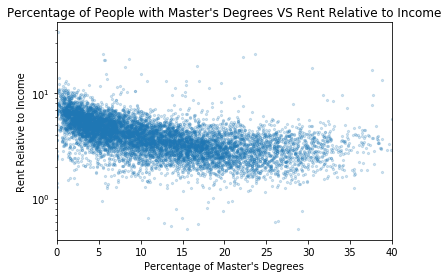

In [ ]:
fig, ax = plt.subplots()
sample = education
plt.scatter(education["masters_degree"], education["rent_relative_to_income"], s=5, alpha=0.2)
plt.title("Percentage of People with Master's Degrees VS Rent Relative to Income")
plt.xlabel("Percentage of Master's Degrees")
plt.ylabel("Rent Relative to Income")
ax.set_yscale('log')
ax.set_xlim([0,40])

A negative correaltion is observed between percentage of Master's degree recipients and rent relative to income. This aligns with our prediction that the more education one has, the higher the likelihood they have higher salaries which would make the Bay more affordable place to rent.

(0, 50)

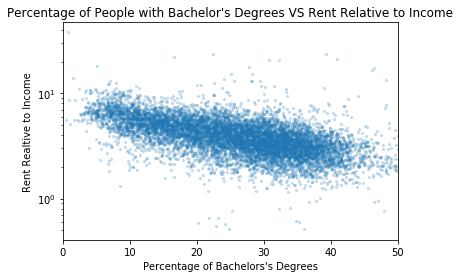

In [ ]:
fig, ax = plt.subplots()
plt.scatter(education["bachelors_degree"], education["rent_relative_to_income"], s=5, alpha=0.2)
plt.title("Percentage of People with Bachelor's Degrees VS Rent Relative to Income")
plt.xlabel("Percentage of Bachelors's Degrees")
plt.ylabel("Rent Realtive to Income")
ax.set_yscale('log')
ax.set_xlim([0,50])

A definite negative correlation is observed. Similar to a Master's Degrees, Bachelor's Degrees would generally indicate higher income thus the Bay renting market is more affordable. 

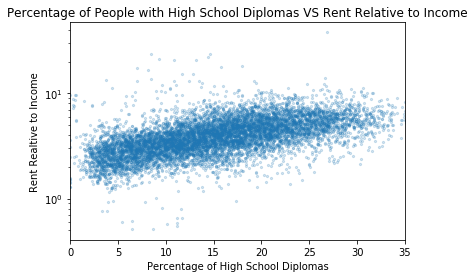

In [ ]:
fig, ax = plt.subplots()
sample = education
plt.scatter(sample["high_school_diploma"], sample["rent_relative_to_income"], s=5, alpha=0.2)
plt.title("Percentage of People with High School Diplomas VS Rent Relative to Income")
plt.xlabel("Percentage of High School Diplomas")
plt.ylabel("Rent Realtive to Income")
ax.set_xlim([0,35])
ax.set_yscale('log')

A positive correlation is observed between percentage of people who have high school as their highest education level and rent relative to income. This indicates that having a bachelor's degree makes an immense impact towards rent affordability in the Bay Area.

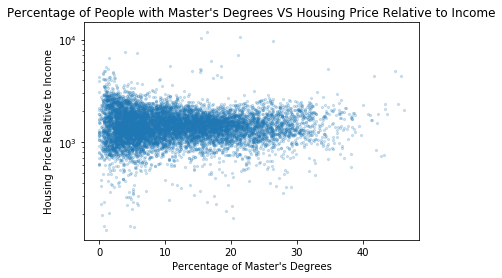

In [ ]:
fig, ax = plt.subplots()
sample = education
plt.scatter(sample["masters_degree"], sample["housing_value_relative_to_income"], s=5, alpha=0.2)
plt.title("Percentage of People with Master's Degrees VS Housing Price Relative to Income")
plt.xlabel("Percentage of Master's Degrees")
plt.ylabel("Housing Price Realtive to Income")
ax.set_yscale('log')

A significant correlation is not observed. This is surprising because one would think that a higher level education and income would depreciate relative housing value. This may point to the Bay Area's exorbitant housing value such that education level does not neccesarily make it more affordable.

(0, 50)

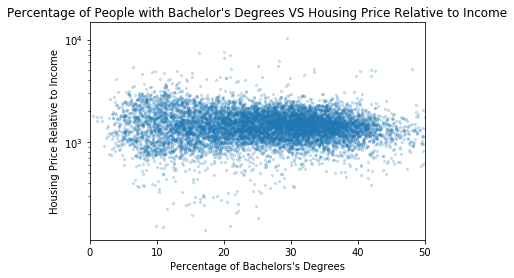

In [ ]:
fig, ax = plt.subplots()
sample = education
plt.scatter(sample["bachelors_degree"], sample["housing_value_relative_to_income"], s=5, alpha=0.2, label='Percent of Households Who Moved Houses')
plt.title("Percentage of People with Bachelor's Degrees VS Housing Price Relative to Income")
plt.xlabel("Percentage of Bachelors's Degrees")
plt.ylabel("Housing Price Relative to Income")
ax.set_yscale('log')
ax.set_xlim([0,50])

A significant correlation is not observed. Like with the analysis for percentage of those with Master's Degrees, education level does not greatly impact housing affordability.

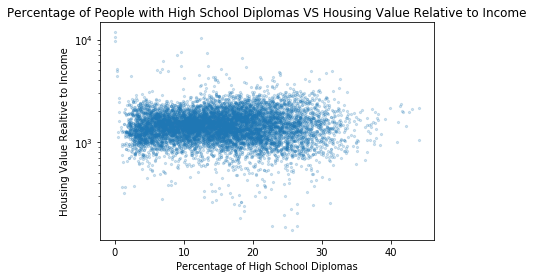

In [ ]:
fig, ax = plt.subplots()
sample = education
plt.scatter(sample["high_school_diploma"], sample["housing_value_relative_to_income"], s=5, alpha=0.2, label='Percent of Households Who Moved Houses')
plt.title("Percentage of People with High School Diplomas VS Housing Value Relative to Income")
plt.xlabel("Percentage of High School Diplomas")
plt.ylabel("Housing Value Realtive to Income")
ax.set_yscale('log')

It is surprising that a positive correlation is not observed here. Areas with larger populations of people with high school diplomas see the same housing value relative to income which may point to the fact that the distribution population does not seem to have a large effect on housing value. 

**Summary**

Below are features that we found to be the most significant correlations for housing value / rent relative to income. They will be used to train our machine learning models.

Rent 


*   Family: Household with families - positive correlation
*  County - Other features like home ownership percentage vary by County
*   Migration: Within the same city - slight positive correlation
*   Race: White - negative correlation
*   Employment: Finance - negative correlation
*   Employment: Information - negative correlation
*   Employment Construction - positive correlation
*   Education: Masters - non-linear negative correlation
*   Education: Bachelors - negative correlation
*   Education: Highschool - slight positive correlation

Housing
*   Construction: Year - slight negative correlation
*   County: Other features like home ownership percentage vary by County
*   Migration: Moved -  slight negative correlation
*   Migration: Moved in from same city - slight negative correlation
*   Race: White - slight negative correlation



**Machine Learning**

First we developed a model to predict housing relative to income. We identified 5 features in our analysis that correlate strongly with housing relative to income. We split housing relative to income into 5 distinct brackets (0-1000, 1000-2000, 2000-3000, 3000-4000, 4000-inf). Since the 2000-3000 bracket comprised more than half of the labels, we conducted data normalization by reducing data with the 2000-3000 to the number of data points in the second most frequent bracket (1000-2000).

In [ ]:
# Run this cell to create a dataset to store your model, or create in the UI

model_dataset_name = 'housing_income'

dataset = bigquery.Dataset(client.dataset(model_dataset_name))
client.create_dataset(dataset)

In [ ]:
%%bigquery --project $project_id

CREATE MODEL `housing_income.housing_income_ratio_predictor`
OPTIONS(model_type='logistic_reg') AS
SELECT
  h.housing_to_income_label AS label,
  h.county AS feature1,
  h.median_year_structure_built AS feature2,
  h.total_diff_house AS feature3,
  h.move_same_city AS feature4,
  h.white AS feature5
FROM
  `cs145-proj3-final.cs145_proj3.housing_value_ML_normalized` h
WHERE
  h.year = '2010' OR h.year = '2012' OR h.year ='2014' OR h.year = '2016'

""


In [ ]:
%%bigquery --project $project_id

SELECT
  *
FROM
  ML.TRAINING_INFO(MODEL `housing_income.housing_income_ratio_predictor`)

,training_run,iteration,loss,eval_loss,learning_rate,duration_ms
0,0,7,0.181464,0.178415,1.6,3824
1,0,6,0.182777,0.179034,6.4,4176
2,0,5,0.184776,0.182831,6.4,4823
3,0,4,0.192244,0.187520,3.2,3978
4,0,3,0.207532,0.202147,1.6,4710
5,0,2,0.239052,0.235029,0.8,3966
6,0,1,0.276626,0.274466,0.4,4415
7,0,0,0.304887,0.304092,0.2,4227


In [ ]:
%%bigquery --project $project_id

SELECT
  *
FROM
  ML.EVALUATE(MODEL `housing_income.housing_income_ratio_predictor`, (
SELECT
  h.housing_to_income_label AS label,
  h.county AS feature1,
  h.median_year_structure_built AS feature2,
  h.total_diff_house AS feature3,
  h.move_same_city AS feature4,
  h.white AS feature5
FROM
  `cs145-proj3-final.cs145_proj3.housing_value_ML_normalized` h
WHERE
  h.year = '2011' OR h.year = '2015'))

,precision,recall,accuracy,f1_score,log_loss,roc_auc
0,0.580353,0.41432,0.631579,0.420664,1.474105,0.845588


The accuracy and precision are far better than chance at discriminating between the 5 brackets which indicates that we selected the right features. Furthermore, our ROC Aread Under the Curve is higher than 0.8, which indicates that our model is a decent performing classifer. Our recall is extremely low, which suggests that our model has low sensitivity and predominantly makes predictions in the two brackets with the largest number of data points. Therefore, performs badly when tested on brackets with low frequencies. The low F1 score suggests low performance of our model.

In [ ]:
%%bigquery --project $project_id

SELECT
  *
FROM
  ML.PREDICT(MODEL `housing_income.housing_income_ratio_predictor`, (
SELECT
  h.housing_to_income_label AS label,
  h.county AS feature1,
  h.median_year_structure_built AS feature2,
  h.total_diff_house AS feature3,
  h.move_same_city AS feature4,
  h.white AS feature5
FROM
  `cs145-proj3-final.cs145_proj3.housing_value_ML_normalized` h
WHERE
  h.year = '2013' OR h.year = '2017'))
LIMIT 10

,predicted_label,predicted_label_probs,label,feature1,feature2,feature3,feature4,feature5
0,1000-2000,"[{'label': '1000-2000', 'prob': 0.262984602226...",0-1000,Napa,1978.0,12.61,1.39,65.40
1,0-1000,"[{'label': '0-1000', 'prob': 0.263227343447657...",0-1000,Marin,1970.0,26.95,9.46,82.42
2,0-1000,"[{'label': '0-1000', 'prob': 0.318372322453853...",0-1000,Solano,1999.0,6.17,1.55,23.06
3,2000-3000,"[{'label': '2000-3000', 'prob': 0.263818523093...",2000-3000,Santa Clara,1986.0,20.58,13.99,13.06
4,2000-3000,"[{'label': '2000-3000', 'prob': 0.301603208785...",2000-3000,Santa Clara,1960.0,12.92,7.83,5.19
5,1000-2000,"[{'label': '1000-2000', 'prob': 0.281123924761...",2000-3000,Santa Clara,1960.0,3.86,1.36,67.63
6,1000-2000,"[{'label': '1000-2000', 'prob': 0.276190265797...",2000-3000,Santa Clara,1963.0,12.07,2.43,69.60
7,2000-3000,"[{'label': '2000-3000', 'prob': 0.297501144033...",2000-3000,Santa Clara,1963.0,5.35,4.85,6.84
8,2000-3000,"[{'label': '2000-3000', 'prob': 0.299811950266...",2000-3000,Santa Clara,1963.0,15.57,10.44,4.74
9,2000-3000,"[{'label': '2000-3000', 'prob': 0.265819610243...",2000-3000,Santa Clara,1967.0,13.95,4.96,32.03


Similarly, we developed a model to predict rent relative to income. We identified 10 features in our analysis that correlate strongly with housing relative to income based on our previous exploration of the dataset. We split our labels into 4 brackets (0-3%, 3-6%, 6-9%, 9-inf%) and built a classifer that can identify the rent relative to income bracket based on the 11 features.

In [ ]:
# Run this cell to create a dataset to store your model, or create in the UI

model_dataset_name = 'rent_income'

dataset = bigquery.Dataset(client.dataset(model_dataset_name))
client.create_dataset(dataset)

In [ ]:
%%bigquery --project $project_id

CREATE MODEL `rent_income.rent_income_ratio_predictor`
OPTIONS(model_type='logistic_reg') AS
SELECT
  r.rent_income_label AS label,
  r.county AS feature1,
  r.percent_family AS feature2,
  r.same_city AS feature3,
  r.white AS feature4,
  r.finance_insurance_real_estate AS feature5,
  r.information AS feature6,
  r.construction AS feature7,
  r.masters_degree	 AS feature8,
  r.bachelors_degree AS feature9,
  r.high_school_diploma AS feature10
FROM
  `cs145-proj3-final.cs145_proj3.rent_ML_normalized` r
WHERE
  r.year = '2010' OR r.year = '2012' OR r.year ='2014' OR r.year = '2016'

""


In [ ]:
%%bigquery --project $project_id

SELECT
  *
FROM
  ML.TRAINING_INFO(MODEL `rent_income.rent_income_ratio_predictor`)

,training_run,iteration,loss,eval_loss,learning_rate,duration_ms
0,0,6,0.171628,0.169133,1.6,4221
1,0,5,0.175075,0.169963,6.4,3952
2,0,4,0.182032,0.178910,3.2,4185
3,0,3,0.197353,0.194608,1.6,4004
4,0,2,0.222026,0.219967,0.8,3765
5,0,1,0.259227,0.258586,0.4,33815
6,0,0,0.306539,0.306669,0.2,3852


In [ ]:
%%bigquery --project $project_id

SELECT
  *
FROM
  ML.EVALUATE(MODEL `rent_income.rent_income_ratio_predictor`, (
SELECT
  r.rent_income_label AS label,
  r.county AS feature1,
  r.percent_family AS feature2,
  r.same_city AS feature3,
  r.white AS feature4,
  r.finance_insurance_real_estate AS feature5,
  r.information AS feature6,
  r.construction AS feature7,
  r.masters_degree	 AS feature8,
  r.bachelors_degree AS feature9,
  r.high_school_diploma AS feature10
FROM
  `cs145-proj3-final.cs145_proj3.rent_ML_normalized` r
WHERE
  r.year = '2011' OR r.year = '2015'))

,precision,recall,accuracy,f1_score,log_loss,roc_auc
0,0.516913,0.528989,0.698,0.52286,1.22441,0.832247


The accuracy is far better than chance at discriminating between the 4 brackets which indicates that we selected the right features. However, since the evaluation loss is higher than the training loss, we may have overfitted our model. Our ROC Aread Under the Curve is higher than 0.8, which indicates that our model is a decent performing classifer. Our recall is in only slightly above 50%, which suggests that our model has low sensitivity. The F1 score for this model is higher than that for our housing_value to income model which indicates that it is overall a better performing model.

In [ ]:
%%bigquery --project $project_id

SELECT
  *
FROM
  ML.PREDICT(MODEL `rent_income.rent_income_ratio_predictor`, (
SELECT
  r.rent_income_label AS label,
  r.county AS feature1,
  r.percent_family AS feature2,
  r.same_city AS feature3,
  r.white AS feature4,
  r.finance_insurance_real_estate AS feature5,
  r.information AS feature6,
  r.construction AS feature7,
  r.masters_degree	 AS feature8,
  r.bachelors_degree AS feature9,
  r.high_school_diploma AS feature10
FROM
  `cs145-proj3-final.cs145_proj3.rent_ML_normalized` r
WHERE
  r.year = '2013' OR r.year = '2017'))
LIMIT 10

,predicted_label,predicted_label_probs,label,feature1,feature2,feature3,feature4,feature5,feature6,feature7,feature8,feature9,feature10
0,3-6,"[{'label': '3-6', 'prob': 0.29744385675332563}...",0-3,Napa,66.78,3.71,57.86,2.80,0.66,8.29,4.95,19.14,14.45
1,6-9,"[{'label': '6-9', 'prob': 0.32742460212594676}...",6-9,Napa,74.50,23.58,27.72,3.87,2.40,7.31,2.49,10.47,16.31
2,0-3,"[{'label': '0-3', 'prob': 0.3468523059245822},...",0-3,Alameda,67.23,4.04,53.29,9.30,4.20,9.02,23.40,32.60,9.20
3,3-6,"[{'label': '3-6', 'prob': 0.33792331047341967}...",3-6,Sonoma,69.04,1.80,53.22,3.85,1.41,9.80,6.66,21.21,14.97
4,0-3,"[{'label': '0-3', 'prob': 0.3524265638728006},...",3-6,San Mateo,73.26,1.67,67.71,3.41,8.17,2.24,20.12,27.49,7.93
5,3-6,"[{'label': '3-6', 'prob': 0.34003650426781906}...",3-6,Santa Clara,65.93,11.09,65.52,3.37,4.57,2.62,14.21,41.55,12.22
6,0-3,"[{'label': '0-3', 'prob': 0.3431938814661073},...",3-6,Alameda,45.51,6.05,42.48,5.73,7.77,3.02,14.29,33.24,11.29
7,3-6,"[{'label': '3-6', 'prob': 0.3345801193664983},...",3-6,Santa Clara,85.74,3.43,62.32,9.19,4.13,2.38,18.09,35.68,11.75
8,0-3,"[{'label': '0-3', 'prob': 0.325463145779295}, ...",3-6,Santa Clara,72.67,3.13,67.86,7.36,1.93,7.31,14.54,33.48,10.68
9,3-6,"[{'label': '3-6', 'prob': 0.35057517986065934}...",3-6,Contra Costa,98.08,2.43,19.52,12.47,8.73,0.24,26.97,51.82,2.25


**Conclusion**

*How has housing value changed over the years in the Bay Area? How has renting prices changed over the years? How has incomes changed?*

Median housing value between the years of 2010-2013 slightly decreased and then started to increase between 2013-2017. Median renting prices have been increasing with a slightly steeper increase rate around 2014. Income per capita has generally been increasing slightly throughout the 8 year period.

*Is there evidence for “house rich, cash poor” ?*

Evidence for “house rich, cash poor” can be seen by looking at looking at how the relation between rent and housing value changed when introducing the qualifier relative to income. Additional evidence can be found when looking at Meidan Housing Value VS Housing Value Relative to Income across the counties in the Bay. Alameda, Contra Costa, San Francisco, San Mateo, Santa Clara, Solano and Sonoma all had a cluster of housing values relative to income that was particularly high during lower values of median housing value. Another point of evidence is the graph showing Housing Value Relative to Income VS Majority Income Housing Bracket since it shows that average housing value relative to income decreases in areas with  more people in higher income brackets. 

*How does the distribution of income across the Bay affect housing and rent relative to income? *

We measured the distribution of income across the Bay in an inequity score that essentially tells us how evenly spread the income brackets are across the Bay. We saw that inequity has increased over the years. It doesn’t seem to have any effect on housing value but correlates with rent relative to income which has also increased over the years.
Are families more or less housing secure than non family households?
We have found evidence that families are less secure for rent compared to non-families. However, families are just as secure for house ownership compared to non-families.

*How does average construction year impact housing affordability?*

Average construction year does not impact housing affordability.

*What are the similarities and differences between the 9 counties that make up the Bay Area?*

Across the 9 counties, as seen in the County section, general trends seem to persist but to different degrees and ranges. For example, across the counties average home value relative to income follow a similar dip but at different ranges of the home value relative to income scale. In the example of average rent relative to income, there is less of a consistent pattern but most seemed to be increasing slightly throughout the years. 

*How does housing affordability relate to household migrations in and out of the Bay?*

Rent affordability does not favor migrations within a city. We also found evidence that housing affordability favors migration from different cities which could be because affordability could be a major incentive for people to move in from a different city.

*How does ethnicity affect housing affordability? How does occupation affect housing affordability? How does education affect housing affordability?*

Ethnicity - We have found significant evidence that both housing and rent affordability favors White people compared to people of color which was expected given the presence of societal privilege. 

Occupation - blue collar workers find rent less affordable that white collar workers. This was expected given the difference in incomes between white and blue collar workers. However, it was surprising that housing affordability favored neither in particular. This is likely because housing value is prohibitively expensive in the Bay Area for both blue and white collar workers.

Education - We have found significant evidence that access to higher education makes both rent and housing more affordable. This was expected given the employment opportunities that higher education can give rise to.


**Future Work**

Because both of our models performed less than ideally, it would be worthwhile to conduct hyper-parameter tuning to improve our model. Furthermore, we could add more layers to our machine learning model to make it more robust and regularization techniques such as dropout can be applied to prevent overfitting. It would also be interesting to find datasets from prior to 2010 to ensure that we are capturing long term trends since temporal data for 8 years may not be enough to generate accurate predictive models. We could also conduct data exploration on age demographics as an additional feature and the impacts it has temporally and geographically for housing value / rent relativeto income. Finally, it would be rewarding to extend the capabilities of our predictive model beyond the Bay Area to capture more general affordability trends across the United States. 